In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
## Suppress warnings related to division by zero
import warnings
warnings.filterwarnings('ignore')
from xhistogram.xarray import histogram
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import gridspec
from scipy import stats
import pandas as pd
import scipy

In [90]:
# If Surface fluxes are available
SF = True
HF_offset =   -5 #W/m2
FW_offset =   0.5 #mm/day
tree_depth = 4

In [91]:
# Thermal expansion, haline contraction and true scale factor
alph = 1.7657*10**-4
bet = 7.5544*10**-4

volnorming = 10**15 #normalising coeffcients
areanorming = 10**12 #normalising coeffcients
ST_scale=bet/alph

# Establish basic constants 
yr2sec = 365.25*24*60*60
dt_OG = xr.open_mfdataset('../BSP_processed/ACCESS_CM2/dtime*.nc')
dt_OG['time'] = np.arange(dt_OG.average_DT.size).astype(float)
dt = dt_OG.rename({'time':'Time'})
rho = 1035 #kg/m^3
Cp = 3992.10322329649
S0=35

# Range of years of which 'early' and 'late' are defined

dyrs = 9
init_early = 1979
init_late = 2006
Early_period = (np.array([init_early,init_early+dyrs]) - init_early)*12+((-1850+1979)*12)
Late_period = (np.array([init_late,init_late+dyrs]) - init_early)*12+((-1850+1979)*12)
range_yrs = init_late-init_early+1

In [92]:
%%time
ACCESS_BSP_data = xr.open_mfdataset('../BSP_processed/ACCESS_CM2/*ACCESS_*%i_bins_*.nc' %(tree_depth))

## Early Period
Part_early = ACCESS_BSP_data.Partitions.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
SA_early =  ACCESS_BSP_data.S_mean.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
CT_early = ACCESS_BSP_data.T_mean.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')-273.15
V_early = ACCESS_BSP_data.V_sum.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
A_early = ACCESS_BSP_data.A_sum.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
# Asection_early = ACCESS_BSP_data.Asection_sum.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')

## Late Period
Part_late = ACCESS_BSP_data.Partitions.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
SA_late =  ACCESS_BSP_data.S_mean.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
CT_late = ACCESS_BSP_data.T_mean.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')-273.15
V_late = ACCESS_BSP_data.V_sum.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
A_late = ACCESS_BSP_data.A_sum.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
# Asection_late = ACCESS_BSP_data.Asection_sum.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')

Basins = ACCESS_BSP_data.Basin.values
# Sections = ACCESS_BSP_data.Section.values


CPU times: user 716 ms, sys: 69.6 ms, total: 786 ms
Wall time: 855 ms


In [93]:

# Flatten the early and late variables to a 1D array
Vol_1 = V_early.values.flatten()
Vol_2 = V_late.values.flatten()
S_1 = SA_early.values.flatten()-S0 # Remove reference salinity S0
S_2 = SA_late.values.flatten()-S0 # Remove reference salinity S0
T_1 = CT_early.values.flatten()
T_2 = CT_late.values.flatten()
A_1 = A_early.values.flatten()
A_2 = A_late.values.flatten()

# Do the same for basin index
Basin_1 = np.zeros_like(V_early)
Basin_2 = np.zeros_like(V_early)
Basin_names = []
for i in range(np.array(Basins).size):
    Basin_1[i,:] = i
    Basin_2[i,:] = i
    for j in range(V_early.shape[-1]):
        #... and for basin name
        Basin_names.append(Basins[i])

Basin_1_inds = Basin_1.flatten()
Basin_2_inds = Basin_2.flatten()

#... and for the edges of the BSP bins
## Here we calculate the mean TS edges averaged over both early and late times
S_start = (0.5*(Part_early.values[:,:,0]+Part_late.values[:,:,0])).flatten()-S0 # Remove reference salinity S0
S_end = (0.5*(Part_early.values[:,:,1]+Part_late.values[:,:,1])).flatten()-S0 # Remove reference salinity S0
T_start = (0.5*(Part_early.values[:,:,2]+Part_late.values[:,:,2])).flatten()
T_end = (0.5*(Part_early.values[:,:,3]+Part_late.values[:,:,3])).flatten()

# Any NaNs are zeroed out
S_1[np.isnan(S_1)] = 0
S_2[np.isnan(S_2)] = 0
T_1[np.isnan(T_1)] = 0
T_2[np.isnan(T_2)] = 0

In [94]:
HF_offset_W = HF_offset*ACCESS_BSP_data.A_sum #W
FW_offset_kg_s = FW_offset*ACCESS_BSP_data.A_sum*rho/(1000*24*3600) #kg/s

In [95]:
## Load SF data here, if provided
if SF:
    ## Calculate the cumulative time integrated surface fluxes 
    HFDS_cumsum = (((ACCESS_BSP_data.hfds_sum+HF_offset_W)*dt.average_DT).cumsum('Time').isel(Time=-1))\
        -(((ACCESS_BSP_data.hfds_sum+HF_offset_W)*dt.average_DT).cumsum('Time').isel(Time=Early_period[0])) # units: J
    WFO_cumsum = ((ACCESS_BSP_data.wfo_sum+FW_offset_kg_s)*dt.average_DT).cumsum('Time').isel(Time=-1)\
         -(((ACCESS_BSP_data.wfo_sum+FW_offset_kg_s)*dt.average_DT).cumsum('Time').isel(Time=Early_period[0]))# units: kg

    ## The final dflux value is then scaled by the time between the middle of t1 and the middle of t2
    dhfds = HFDS_cumsum*((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-Early_period[0]))
    dwfo = WFO_cumsum*((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-Early_period[0]))

    ## Convert dflux to equivalent T or S change

    dT_hfds = dhfds/(Cp*rho*V_early) # units: C
    dS_wfo = -dwfo*S0/(rho*V_early) # units: g/kg

    time = ACCESS_BSP_data.Time.values
    S_pre = SA_early.values.flatten()-S0
    S_1 = SA_early.values.flatten()-S0+dS_wfo.values.flatten()
    T_pre = CT_early.values.flatten()
    T_1 = CT_early.values.flatten()+dT_hfds.values.flatten()

    S_1[np.isnan(S_1)] = 0
    T_1[np.isnan(T_1)] = 0
    S_1[~np.isfinite(S_1)] = 0
    T_1[~np.isfinite(T_1)] = 0

In [96]:
Opt_result = xr.open_mfdataset('../Optimisation_results/ACCESS_CM2_known_offset_transports.nc')

RAPID_example = xr.open_mfdataset('~/UNSW_Work/RAPID_AMOC/moc_transports.nc')
    
mean_MOC_RAPID = RAPID_example.moc_mar_hc10.mean('time').values

In [97]:
# Array defining the connection between the 9 basins;
# 1 = connected (sign convention: North = +, East = +), 0 = disconnected
d_ij = np.zeros((Basins.size,Basins.size))

d_ij[0,:] = [1, -1, 0, 0, 0, 0, 0, 0, 0]
d_ij[1,:] = [1, 1, -1, 0, 0, 0, 0, 0, 0]
d_ij[2,:] = [0, 1, 1, -1, 0, 0, 0, 0, 0]
d_ij[3,:] = [0, 0, 1, 1, 0, 0, 0, 0, -1]
d_ij[4,:] = [0, 0, 0, 0, 1, 0, 1, 0, -1]
d_ij[5,:] = [0, 0, 0, 0, 0, 1, 1, 0, -1]
d_ij[6,:] = [0, 0, 0, 0, -1, -1, 1, 1, 0]
d_ij[7,:] = [0, 0, 0, 0, 0, 0, -1, 1, 0]
d_ij[8,:] = [0, 0, 0, 1, 1, 1, 0, 0, 1]

d = {Basins[0]: d_ij.T[0,:],\
    Basins[1]: d_ij.T[1,:],\
    Basins[2]: d_ij.T[2,:],\
    Basins[3]: d_ij.T[3,:],\
    Basins[4]: d_ij.T[4,:],\
    Basins[5]: d_ij.T[5,:],\
    Basins[6]: d_ij.T[6,:],\
    Basins[7]: d_ij.T[7,:],\
    Basins[8]: d_ij.T[8,:]}
    
table = pd.DataFrame(data=d, index=Basins)
table


,Polar N. Atlantic,Subtropical N. Atlantic,Eq. Atlantic,S. Atlantic,Indian,S. Pacific,Eq. Pacific,N. Pacific,Southern Ocean
Polar N. Atlantic,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Subtropical N. Atlantic,1.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
Eq. Atlantic,0.0,1.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0
S. Atlantic,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,-1.0
Indian,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-1.0
S. Pacific,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,-1.0
Eq. Pacific,0.0,0.0,0.0,0.0,-1.0,-1.0,1.0,1.0,0.0
N. Pacific,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0
Southern Ocean,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0


In [98]:
g_ij = Opt_result.gij.values

section_trans = np.zeros((Vol_1.size,Vol_1.size))
for i in (range(Vol_1.size)):
    for j in range(Vol_2.size):
        if d_ij[int(Basin_1_inds[i]), int(Basin_2_inds[j])]!=0:
            if Basin_names[i] != Basin_names[j]:
                section_trans[i,j] = g_ij[i,j]/(range_yrs*yr2sec*10**6)*d_ij[int(Basin_1_inds[i]), int(Basin_2_inds[j])]

int_section_trans = np.zeros((Basins.size, Basins.size))
for i in (range(Basins.size)):
    for j in range(Basins.size):
        int_section_trans[i,j] = np.nansum(section_trans[V_early.shape[1]*i:(V_early.shape[1]*(i+1)),V_early.shape[1]*j:(V_early.shape[1]*(j+1))])

section_trans_temp = np.zeros((Vol_1.size, Basins.size))
for j in range(Basins.size):
    section_trans_temp[:,j] = np.nansum(section_trans[:,V_early.shape[1]*j:(V_early.shape[1]*(j+1))],axis=-1)

In [99]:
dS_adj = Opt_result.dS_adjustment.values.reshape(Basins.size,SA_early.shape[-1])
dT_adj = Opt_result.dT_adjustment.values.reshape(Basins.size,SA_early.shape[-1])

dwfo_adj = -dS_adj*(rho*V_late.values)/S0 # units: kg
dhfds_adj = dT_adj*(Cp*rho*V_late.values) # units: J

## Get it in W/m2 and mm/day
dhfds_flux_adj = dhfds_adj/(range_yrs*yr2sec*A_late.values)
dwfo_flux_adj = dwfo_adj/(range_yrs*yr2sec*A_late.values*rho)*1000*24*3600

In [100]:
basin_connex = np.array([[0,1],
                [1,2],
                [2,3],
                [3,8],
                [4,8],
                [4,6],
                [5,8],
                [6,5],
                [7,6]]).astype(int)

T_joined = np.zeros((int(np.size(basin_connex)/2), int(V_early.shape[1]*2)))
S_joined = np.zeros((int(np.size(basin_connex)/2), int(V_early.shape[1]*2)))
section_joined = np.zeros((int(np.size(basin_connex)/2), int(V_early.shape[1]*2)))

for i in range(int(np.size(basin_connex)/2)):
    T_joined[i,:] = np.concatenate([T_1[V_early.shape[1]*basin_connex[i][0]:(V_early.shape[1]*(basin_connex[i][0]+1))],T_1[V_early.shape[1]*basin_connex[i][1]:(V_early.shape[1]*(basin_connex[i][1]+1))]])
    S_joined[i,:] = np.concatenate([S_1[V_early.shape[1]*basin_connex[i][0]:(V_early.shape[1]*(basin_connex[i][0]+1))],S_1[V_early.shape[1]*basin_connex[i][1]:(V_early.shape[1]*(basin_connex[i][1]+1))]])
    section_joined[i,:] = np.concatenate([section_trans_temp[V_early.shape[1]*basin_connex[i][0]:(V_early.shape[1]*(basin_connex[i][0]+1)),basin_connex[i][1]],\
        section_trans_temp[V_early.shape[1]*basin_connex[i][1]:(V_early.shape[1]*(basin_connex[i][1]+1)),basin_connex[i][0]]])

# Calculate potential density to compare with ACCESS-CM2 results
import gsw

potrho0 = gsw.sigma0(S_joined+S0,T_joined)+1000
potrho1 = gsw.sigma1(S_joined+S0,T_joined)+1000

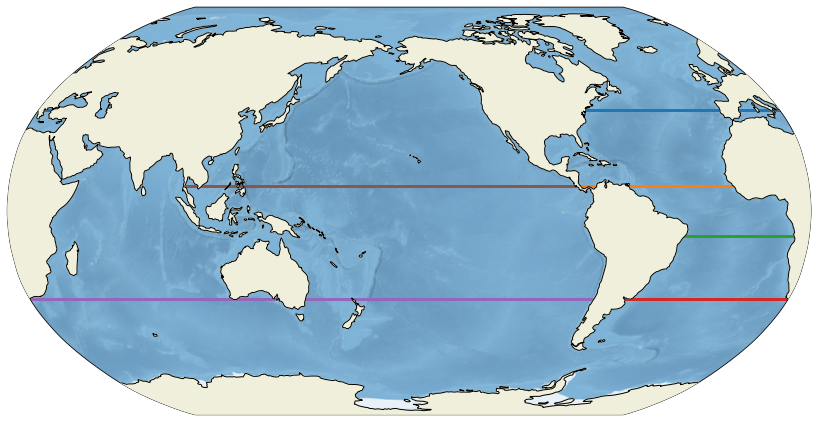

In [15]:
fig  = plt.figure(1, figsize = (17.5, 7.5))
gs = gridspec.GridSpec(1,1)
gs.update(wspace = 0.4, hspace=0)

ax1 = plt.subplot(gs[0,0], projection=ccrs.Robinson(central_longitude=-160))
minv, maxv = 0,8

ax1.stock_img()
ax1.coastlines(zorder=101)

## SECTIONS
# Pacific Sector
ax1.plot([145,300],[-35,-35], transform = ccrs.PlateCarree(), linewidth = 3, color='#9467bd')
# ax1.plot([145,300],[-10,-10], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([100,278],[10,10], transform = ccrs.PlateCarree(), linewidth = 3, color='#8c564b')

# Indian Sector
ax1.plot([20,145],[-35,-35], transform = ccrs.PlateCarree(), linewidth = 3, color='#9467bd')
# ax1.plot([145,110,100,100],[-10,-10,0,20], transform = ccrs.PlateCarree(), linewidth = 2, color='black')

# Atlantic Sector
ax1.plot([300,360],[-35,-35], transform = ccrs.PlateCarree(), linewidth = 3, color='#d62728')
ax1.plot([0,20],[-35,-35], transform = ccrs.PlateCarree(), linewidth = 3, color='#d62728')
ax1.plot([300,360],[-10,-10], transform = ccrs.PlateCarree(), linewidth = 3, color='#2ca02c')
ax1.plot([0,25],[-10,-10], transform = ccrs.PlateCarree(), linewidth = 3, color='#2ca02c')
ax1.plot([278,360],[10,10], transform = ccrs.PlateCarree(), linewidth = 3, color='#ff7f0e')
ax1.plot([280,360],[40,40], transform = ccrs.PlateCarree(), linewidth = 3, color='#1f77b4')
ax1.plot([0,25],[40,40], transform = ccrs.PlateCarree(), linewidth = 3, color='#1f77b4')

ax1.add_feature(cfeature.LAND, zorder=100)

plt.savefig('../Figures/raw_map.png', bbox_inches='tight', dpi=300)
plt.show()

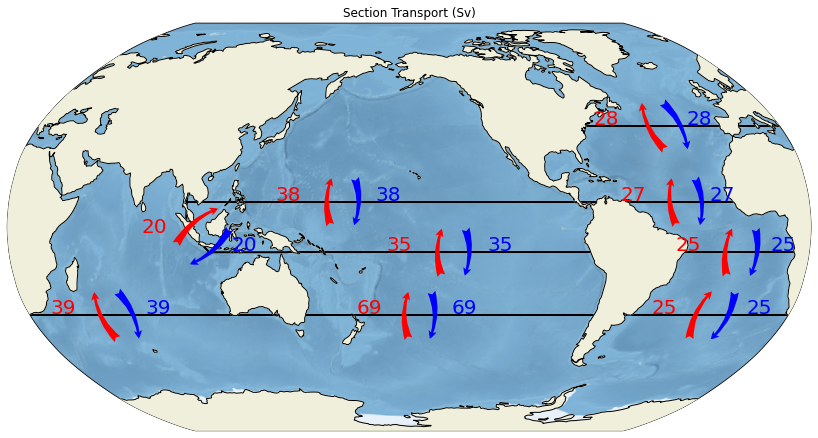

In [101]:
fig  = plt.figure(1, figsize = (17.5, 7.5))
gs = gridspec.GridSpec(1,1)
gs.update(wspace = 0.4, hspace=0)

ax1 = plt.subplot(gs[0,0], projection=ccrs.Robinson(central_longitude=-160))
minv, maxv = 0,8

ax1.stock_img()
ax1.coastlines(zorder=101)

## SECTIONS
# Pacific Sector
ax1.plot([145,300],[-35,-35], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([145,300],[-10,-10], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([100,280],[10,10], transform = ccrs.PlateCarree(), linewidth = 2, color='black')

# Indian Sector
ax1.plot([25,145],[-35,-35], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([145,110,100,100],[-10,-10,0,20], transform = ccrs.PlateCarree(), linewidth = 2, color='black')

# Atlantic Sector
ax1.plot([300,360],[-35,-35], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([0,25],[-35,-35], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([300,360],[-10,-10], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([0,25],[-10,-10], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([280,360],[10,10], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([280,360],[40,40], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([0,25],[40,40], transform = ccrs.PlateCarree(), linewidth = 2, color='black')

ax1.add_feature(cfeature.LAND, zorder=100)

## S PAC <> SO

ax1.annotate('', xy=(200,-25), xytext=(200, -45),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(abs(int(int_section_trans[5,-1])), xy=(200,-25), xytext=(220, -34.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=20, zorder=103)

ax1.annotate('', xy=(210,-45), xytext=(210, -25),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(int(int_section_trans[-1,5]), xy=(175,-25), xytext=(175, -34.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=20, zorder=103)

## EQ PAC <> S PAC

ax1.annotate('', xy=(215,0), xytext=(215, -20),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(abs(int(int_section_trans[6,5])), xy=(235,-9.5), xytext=(235, -9.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=20, zorder=103)

ax1.annotate('', xy=(225,-20), xytext=(225, 0),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(int(int_section_trans[5,6]), xy=(190,-9.5), xytext=(190, -9.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=20, zorder=103)

## EQ PAC <> N PAC

ax1.annotate('', xy=(165,20), xytext=(165, 0),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(abs(int(int_section_trans[7,6])), xy=(185,10.5), xytext=(185, 10.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=20, zorder=103)

ax1.annotate('', xy=(175,0), xytext=(175, 20),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(abs(int(int_section_trans[6,7])), xy=(140,10.5), xytext=(140, 10.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=20, zorder=103)

## IND <> SO

ax1.annotate('', xy=(55,-25), xytext=(55, -45),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)
ax1.annotate(abs(int(int_section_trans[4,-1])), xy=(75,-25), xytext=(75, -34.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=20, zorder=103)

ax1.annotate('', xy=(65,-45), xytext=(65, -25),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(int(int_section_trans[-1,4]), xy=(30,-25), xytext=(30, -34.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=20, zorder=103)

## EQ PAC <> IND

ax1.annotate('', xy=(115, 7.5), xytext=(95,-7.5),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(abs(int(int_section_trans[6,4])), xy=(75,-9.5), xytext=(120, -9.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=20, zorder=103)

ax1.annotate('', xy=(100, -15), xytext=(120,0),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(int(int_section_trans[4,6]), xy=(80,-2.5), xytext=(80, -2.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=20, zorder=103)


## S ATL <> SO

ax1.annotate('', xy=(340,-25), xytext=(340, -45),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(abs(int(int_section_trans[3,-1])), xy=(360,-25), xytext=(360, -34.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=20, zorder=103)

ax1.annotate('', xy=(350,-45), xytext=(350, -25),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(int(int_section_trans[-1,3]), xy=(315,-25), xytext=(315, -34.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=20, zorder=103)

## EQ ATL <> S ATL

ax1.annotate('', xy=(345,0), xytext=(345, -20),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(abs(int(int_section_trans[2,3])), xy=(2.5,-9.5), xytext=(2.5, -9.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=20, zorder=103)

ax1.annotate('', xy=(355,-20), xytext=(355, 0),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(int(int_section_trans[3,2]), xy=(320,-9.5), xytext=(320, -9.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=20, zorder=103)

## EQ ATL <> ST ATL

ax1.annotate('', xy=(320,20), xytext=(320, 0),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(abs(int(int_section_trans[1,2])), xy=(335,10.5), xytext=(335, 10.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=20, zorder=103)

ax1.annotate('', xy=(330,0), xytext=(330, 20),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(abs(int(int_section_trans[2,1])), xy=(295,10.5), xytext=(295, 10.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=20, zorder=103)

## ST ATL <> POL ATL

ax1.annotate('', xy=(320,50), xytext=(320, 30),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)
ax1.annotate(abs(int(int_section_trans[0,1])), xy=(335,40.5), xytext=(335, 40.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=20, zorder=103)

ax1.annotate('', xy=(330,30), xytext=(330, 50),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(abs(int(int_section_trans[1,0])), xy=(290,40.5), xytext=(290, 40.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=20, zorder=103)

plt.title('Section Transport (Sv)')
if SF:
    plt.savefig('../Figures/Land_mask_ACCESS_knownSF.png', bbox_inches='tight', dpi=300)
else:
    plt.savefig('../Figures/Land_mask_ACCESS_freerun.png', bbox_inches='tight', dpi=300)
plt.show()

In [102]:
section_names = np.array([r'40$^{\circ}$N (Atlantic)', 
                r'10$^{\circ}$N (Atlantic)',
                r'10$^{\circ}$S (Atlantic)', 
                r'35$^{\circ}$S (Atlantic)',
                r'35$^{\circ}$S (Indian)',
                r'110 - 100 $^{\circ}$E, 10 - 0 $^{\circ}$S (ITF)',
                r'35$^{\circ}$S (Pacific)',
                r'10$^{\circ}$S (Pacific)',
                r'10$^{\circ}$N (Pacific)'])


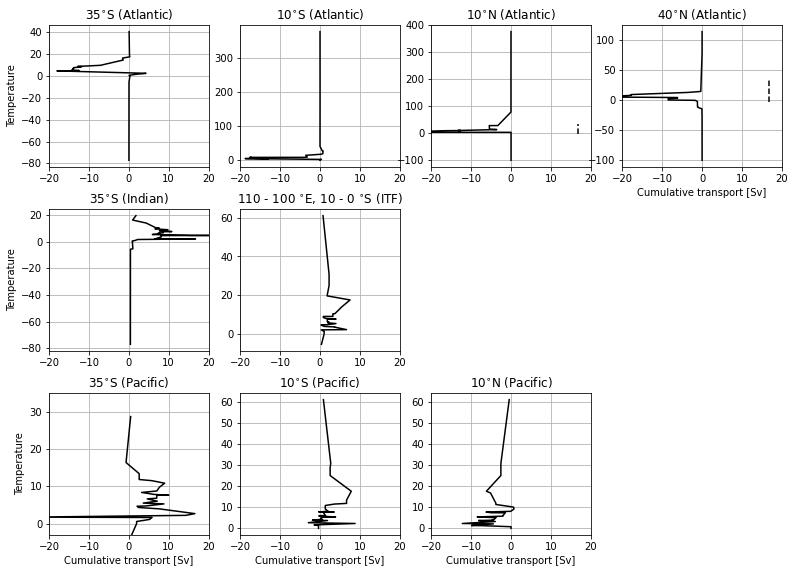

In [103]:
fig  = plt.figure(1, figsize = (17.5*0.75, 12.5*0.75))
gs = gridspec.GridSpec(3,4)
gs.update(wspace = 0.2, hspace=0.3)

ax1, ax2, ax3, ax4 = plt.subplot(gs[0,0]), \
           plt.subplot(gs[0,1]), \
           plt.subplot(gs[0,2]) , \
           plt.subplot(gs[0,3])

ax5, ax6 = plt.subplot(gs[1,0]), \
           plt.subplot(gs[1,1])

ax7, ax8,ax9 = plt.subplot(gs[2,0]), \
           plt.subplot(gs[2,1]), \
            plt.subplot(gs[2,2])

ax1.plot(-np.nancumsum(section_joined[3,:][np.argsort(T_joined[3,:])][::-1])[::-1], T_joined[3,:][np.argsort(T_joined[3,:])], '-k')
ax1.set_title(section_names[3])
# ax1.set_ylim(-3,35)
ax1.set_xlim(-20,20)

ax2.plot(-np.nancumsum(section_joined[2,:][np.argsort(T_joined[2,:])][::-1])[::-1], T_joined[2,:][np.argsort(T_joined[2,:])], '-k')
ax2.set_title(section_names[2])
# ax2.set_ylim(-3,35)
ax2.set_xlim(-20,20)

ax3.plot(-np.nancumsum(section_joined[1,:][np.argsort(T_joined[1,:])][::-1])[::-1], T_joined[1,:][np.argsort(T_joined[1,:])], '-k')
ax3.vlines(mean_MOC_RAPID, -3,35, color='black', linestyle='dashed')
ax3.set_title(section_names[1])
# ax3.set_ylim(-3,35)
ax3.set_xlim(-20,20)

ax4.plot(-np.nancumsum(section_joined[0,:][np.argsort(T_joined[0,:])][::-1])[::-1], T_joined[0,:][np.argsort(T_joined[0,:])], '-k')
ax4.vlines(mean_MOC_RAPID, -3,35, color='black', linestyle='dashed')
ax4.set_title(section_names[0])
# ax4.set_ylim(-3,35)
ax4.set_xlim(-20,20)
ax4.set_xlabel('Cumulative transport [Sv]')

ax5.plot(-np.nancumsum(section_joined[4,:][np.argsort(T_joined[4,:])][::-1])[::-1], T_joined[4,:][np.argsort(T_joined[4,:])], '-k')
ax5.set_title(section_names[4])
# ax5.set_ylim(-3,35)
ax5.set_xlim(-20,20)

ax6.plot(-np.nancumsum(section_joined[5,:][np.argsort(T_joined[5,:])][::-1])[::-1], T_joined[5,:][np.argsort(T_joined[5,:])], '-k')
ax6.set_title(section_names[5])
# ax6.set_ylim(-3,35)
ax6.set_xlim(-20,20)

ax7.plot(-np.nancumsum(section_joined[6,:][np.argsort(T_joined[6,:])][::-1])[::-1], T_joined[6,:][np.argsort(T_joined[6,:])], '-k')
ax7.set_title(section_names[6])
ax7.set_ylim(-3,35)
ax7.set_xlim(-20,20)
ax7.set_xlabel('Cumulative transport [Sv]')

ax8.plot(-np.nancumsum(section_joined[7,:][np.argsort(T_joined[7,:])][::-1])[::-1], T_joined[7,:][np.argsort(T_joined[7,:])], '-k')
ax8.set_title(section_names[7])
# ax8.set_ylim(-3,35)
ax8.set_xlim(-20,20)
ax8.set_xlabel('Cumulative transport [Sv]')

ax9.plot(-np.nancumsum(section_joined[8,:][np.argsort(T_joined[8,:])][::-1])[::-1], T_joined[8,:][np.argsort(T_joined[8,:])], '-k')
ax9.set_title(section_names[8])
# ax9.set_ylim(-3,35)
ax9.set_xlim(-20,20)
ax9.set_xlabel('Cumulative transport [Sv]')

ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax5.grid()
ax6.grid()
ax7.grid()
ax8.grid()
ax9.grid()

ax1.set_ylabel('Temperature')
ax5.set_ylabel('Temperature')
ax7.set_ylabel('Temperature')

if SF:
    plt.savefig('../Figures/Section_transports_Temp_space_ACCESS_knownSF.png', bbox_inches='tight', dpi=300)
else:
    plt.savefig('../Figures/Section_transports_Temp_space_ACCESS_freerun.png', bbox_inches='tight', dpi=300)

plt.show()

In [104]:
## Interpolate transports onto same T grid

T_grid = np.linspace(-150,500,500)
transports_interped = np.zeros((section_names.size, T_grid.size))
for i in range(section_names.size):
    f_interp = scipy.interpolate.interp1d(T_joined[i,:][np.argsort(T_joined[i,:])], \
        np.nancumsum(section_joined[i,:][np.argsort(T_joined[i,:])][::-1])[::-1], \
            fill_value=(np.nancumsum(section_joined[i,:][np.argsort(T_joined[i,:])][::-1])[::-1][0],\
                np.nancumsum(section_joined[i,:][np.argsort(T_joined[i,:])][::-1])[::-1][-1]),\
                    bounds_error=False)

    transports_interped[i,:] = f_interp(T_grid)

In [105]:
Atl_lats = np.array([-90,-35,-10,10,40,90])
Pac_lats = np.array([-90,-35,-10,10,90])


## We ignore the ITF bit here

Pac_overturning = np.array([np.zeros_like(T_grid), 
(transports_interped[4,:])\
+(transports_interped[6,:]),
(transports_interped[7,:]),
(transports_interped[8,:]),
np.zeros_like(T_grid)])

Atl_overturning = np.array([np.zeros_like(T_grid), (transports_interped[3,:]),
(transports_interped[2,:]),
(transports_interped[1,:]),
(transports_interped[0,:]),
np.zeros_like(T_grid)])

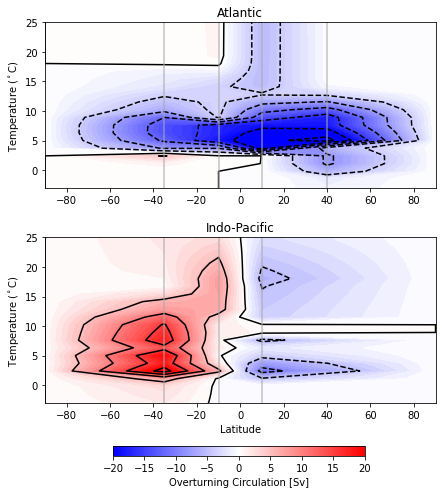

In [106]:

fig  = plt.figure(1, figsize = (17.5*0.4, 17.5*0.4))
gs = gridspec.GridSpec(2,2)
gs.update(wspace = 0.2, hspace=0.3)

ax1, ax2 = plt.subplot(gs[0,:]), \
           plt.subplot(gs[1,:])

ax1.contourf(Atl_lats, T_grid, -np.moveaxis(Atl_overturning,0,-1), 50,vmin=-20, vmax=20, cmap=plt.cm.bwr)
ax1.contour(Atl_lats, T_grid, -np.moveaxis(Atl_overturning,0,-1), level=np.linspace(-20,20,8), colors='black', linewidth=0.5)
ax1.vlines(Atl_lats[1:-1],-3,35, color='darkgrey', alpha=0.7)
ax2.contourf(Pac_lats, T_grid, -np.moveaxis(Pac_overturning,0,-1), 50,vmin=-20, vmax=20, cmap=plt.cm.bwr)
ax2.contour(Pac_lats, T_grid, -np.moveaxis(Pac_overturning,0,-1), level=np.linspace(-20,20,8), colors='black', linewidth=0.5)
ax2.vlines(Pac_lats[1:-1],-3,35, color='darkgrey', alpha=0.7)

# ax1.plot(np.cumsum((temp_binned_transport[3,:])[::-1])[::-1],temp_mid, '-k')
ax1.set_title('Atlantic')
ax2.set_title('Indo-Pacific')
ax1.set_ylim(-3,25)
ax2.set_ylim(-3,25)
ax2.set_xlabel('Latitude')
ax2.set_ylabel('Temperature ($^\circ$C)')
ax1.set_ylabel('Temperature ($^\circ$C)')

cax = fig.add_axes([0.26, 0.02, 0.5, 0.02])

m = plt.cm.ScalarMappable(cmap=plt.cm.bwr)
m.set_clim(-20, 20)
cbar = fig.colorbar(m, cax=cax, orientation='horizontal')
cbar.set_label('Overturning Circulation [Sv]') 

if SF:
    plt.savefig('../Figures/Overturning_ACCESS_knownSF.png', bbox_inches='tight', dpi=300)
else:
    plt.savefig('../Figures/Overturning_ACCESS_freerun.png', bbox_inches='tight', dpi=300)

plt.show()

In [107]:

Actual_Sfunc = xr.open_mfdataset('../TS_Sfunction/temp_lat_Sfunc_79_14_hist.nc')

section_trans_actual = np.zeros((Atl_lats.size,Actual_Sfunc.temp_bin.size))
T_bins_actual = Actual_Sfunc.temp_bin.values
for i in range(Atl_lats.size-2):
    section_trans_actual[i+1,:] = Actual_Sfunc.histogram_temp.sel(grid_yu_ocean=Atl_lats[-2-i], method='nearest').values

Glob_overturning = np.zeros_like(Atl_overturning)
for i in range(5):
    if i == 5:
        Glob_overturning[i,:] = Atl_overturning[i,:]
    else:
        Glob_overturning[i,:] = Atl_overturning[i,:]+Pac_overturning[i,:]

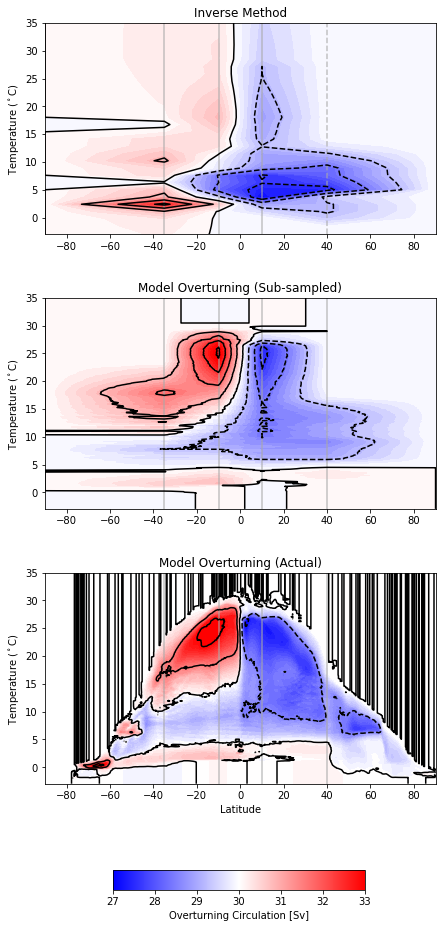

In [108]:


fig  = plt.figure(1, figsize = (17.5*0.4, 17.5*0.8))
gs = gridspec.GridSpec(3,2)
gs.update(wspace = 0.2, hspace=0.3)

ax1, ax2, ax3 = plt.subplot(gs[0,:]), \
           plt.subplot(gs[1,:]),\
            plt.subplot(gs[2,:])

minv = -30
maxv = 30

ax1.contourf(Atl_lats, T_grid, -np.moveaxis(Glob_overturning,0,-1), 50,vmin=minv, vmax=maxv, cmap=plt.cm.bwr)
ax1.vlines(Atl_lats[1:-2],-3,35, color='darkgrey', alpha=0.7)
ax1.vlines(Atl_lats[-2],-3,35, color='darkgrey', linestyle='dashed', alpha=0.7)
ax1.contour(Atl_lats, T_grid, -np.moveaxis(Glob_overturning,0,-1), level=np.linspace(minv,maxv,8), colors='black', linewidth=0.5)

ax2.contourf(Atl_lats[::-1], T_bins_actual, 1*section_trans_actual.T, 50,vmin=minv, vmax=maxv, cmap=plt.cm.bwr, add_colorbar=False)
ax2.vlines(Atl_lats[1:-2],-3,35, color='darkgrey', alpha=0.7)
ax2.vlines(Atl_lats[-2],-3,35, color='darkgrey', alpha=0.7)
ax2.contour(Atl_lats[::-1], T_bins_actual, 1*section_trans_actual.T, level=np.linspace(minv,maxv,8), colors='black', linewidth=0.5)

(1*Actual_Sfunc.histogram_temp.T).plot.contourf(levels=50, vmin=minv, vmax=maxv, cmap=plt.cm.bwr, add_colorbar=False)
ax3.vlines(Atl_lats[1:-2],-3,35, color='darkgrey', alpha=0.7)
ax3.vlines(Atl_lats[-2],-3,35, color='darkgrey', alpha=0.7)

(1*Actual_Sfunc.histogram_temp.T).plot.contour(level=np.linspace(minv,maxv,8), colors='black', linewidth=0.5)

cax = fig.add_axes([0.26, 0.02, 0.5, 0.02])

m = plt.cm.ScalarMappable(cmap=plt.cm.bwr)
m.set_clim(-minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='horizontal')
cbar.set_label('Overturning Circulation [Sv]') 

ax1.set_title('Inverse Method')
ax2.set_title('Model Overturning (Sub-sampled)')
ax3.set_title('Model Overturning (Actual)')

ax1.set_ylim(-3,35)
ax2.set_ylim(-3,35)
ax3.set_ylim(-3,35)
ax3.set_xlim(-90,90)

ax3.set_xlabel('Latitude')
ax2.set_ylabel('Temperature ($^\circ$C)')
ax1.set_ylabel('Temperature ($^\circ$C)')
ax3.set_ylabel('Temperature ($^\circ$C)')

if SF:
    plt.savefig('../Figures/GlobOverturning_knownSF.png', bbox_inches='tight', dpi=300)
else:
    plt.savefig('../Figures/GlobOverturning_freerun.png', bbox_inches='tight', dpi=300)


plt.show()


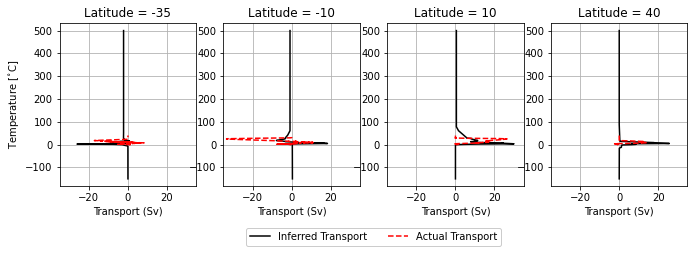

In [109]:

fig, axs = plt.subplots(1,4, figsize=(7.5*1.5,2.5*1.2), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=0.2)
axs = axs.ravel()

for j in (range(Atl_lats.size-2)):
    axs[-(j+1)].set_title('Latitude = '+str(Atl_lats[1:-1][::-1][j]))
    axs[-(j+1)].plot(Glob_overturning[-j-2,:], T_grid, '-k', label = 'Inferred Transport')
    axs[-(j+1)].plot(-1*section_trans_actual.T[:,j+1], T_bins_actual, '--r', label = 'Actual Transport')
    axs[-(j+1)].grid()
    axs[j].set_xlim(-35,35)
    # axs[j].set_ylim(-150,500)
    axs[j].set_xlabel('Transport (Sv)')

axs[0].set_ylabel('Temperature [$^{\circ}$C]')
axs[0].legend(ncol=2, framealpha=1, bbox_to_anchor=(2.3, -0.31), loc='center')
plt.savefig('../Figures/AMOC_Validation_Global.png', dpi=300, bbox_inches='tight')
plt.show()




In [110]:
heat_trans = T_joined*section_joined*rho*Cp*10**6
HF_section_tot = np.nansum(heat_trans, axis=-1)/10**12

OHC_early = rho*Cp*((ACCESS_BSP_data.T_mean-273.15)*ACCESS_BSP_data.V_sum).isel(Time=slice(Early_period[0],Early_period[1])).mean('Time').sum('Depth') # J
OHC_late = rho*Cp*((ACCESS_BSP_data.T_mean-273.15)*ACCESS_BSP_data.V_sum).isel(Time=slice(Late_period[0],Late_period[1])).mean('Time').sum('Depth') # J

hfds_early = ((ACCESS_BSP_data.hfds_sum+HF_offset_W)*dt.average_DT).isel(Time=slice(Early_period[0],Late_period[1])).cumsum('Time').sel(Time=slice(Early_period[0],Early_period[1])).mean('Time').sum('Depth') # J
hfds_late = ((ACCESS_BSP_data.hfds_sum+HF_offset_W)*dt.average_DT).isel(Time=slice(Early_period[0],Late_period[1])).cumsum('Time').sel(Time=slice(Late_period[0],Late_period[1])).mean('Time').sum('Depth') # J

hfds_change = ((hfds_late-hfds_early)/(range_yrs*yr2sec*10**12)).values # units: TW
OHC_change = ((OHC_late-OHC_early)/(range_yrs*yr2sec*10**12)).values # units: TW

hfds_adj_change = np.nansum(dhfds_adj, axis=-1)/(range_yrs*yr2sec*10**12)


In [111]:
salt_trans = S_joined/S0*section_joined # Sv
FWF_section_tot = np.nansum(salt_trans, axis=-1)

OSC_early = ((-ACCESS_BSP_data.S_mean/S0*ACCESS_BSP_data.V_sum)).isel(Time=slice(Early_period[0],Early_period[1])).mean('Time').sum('Depth') # m3
OSC_late = ((-ACCESS_BSP_data.S_mean/S0*ACCESS_BSP_data.V_sum)).isel(Time=slice(Late_period[0],Late_period[1])).mean('Time').sum('Depth') # m3

wfo_early = ((ACCESS_BSP_data.wfo_sum+FW_offset_kg_s)*dt.average_DT).isel(Time=slice(Early_period[0],Late_period[1])).cumsum('Time').sel(Time=slice(Early_period[0],Early_period[1])).mean('Time').sum('Depth')/rho # m3
wfo_late = ((ACCESS_BSP_data.wfo_sum+FW_offset_kg_s)*dt.average_DT).isel(Time=slice(Early_period[0],Late_period[1])).cumsum('Time').sel(Time=slice(Late_period[0],Late_period[1])).mean('Time').sum('Depth')/rho # m3

wfo_change = ((wfo_late-wfo_early)/(range_yrs*yr2sec*10**6)).values # units: Sv
OSC_change = ((OSC_late-OSC_early)/(range_yrs*yr2sec*10**6)).values # units: Sv

wfo_adj_change = np.nansum(dwfo_adj, axis=-1)/(rho*range_yrs*yr2sec*10**6)


In [112]:
mask_EN4_xr = xr.open_mfdataset('../Basin_mask/mask_EN4.nc')
mask_EN4 = (mask_EN4_xr.__xarray_dataarray_variable__.isel(depth=0).values)
# Modify mask_EN4 to be hard borders
mask_EN4_modded = np.copy(mask_EN4)

for i in range(Basins.size):
    mask_EN4_modded[i,:,:] = np.ma.where(mask_EN4[i,:,:]>=0.5, 1, np.zeros_like(mask_EN4[i,:,:]))

OHU_remapped = np.zeros_like(mask_EN4_modded)
hfds_remapped = np.zeros_like(mask_EN4_modded)

for j in range(Basins.size):
    OHU_remapped[j,:,:] = mask_EN4_modded[j,:,:]*OHC_change[j]
    hfds_remapped[j,:,:] = mask_EN4_modded[j,:,:]*hfds_change[j]

## LOAD T and S data from a gridded observations (e.g., we use EN4 here)
## For the purposes of the tutorial we only select the first 3 months of the data
data = xr.open_mfdataset('~/UNSW_work/EN4_Data/EN_data/EN4_CT_SA_0*')

lats = data.lat.values
lons = data.lon.values


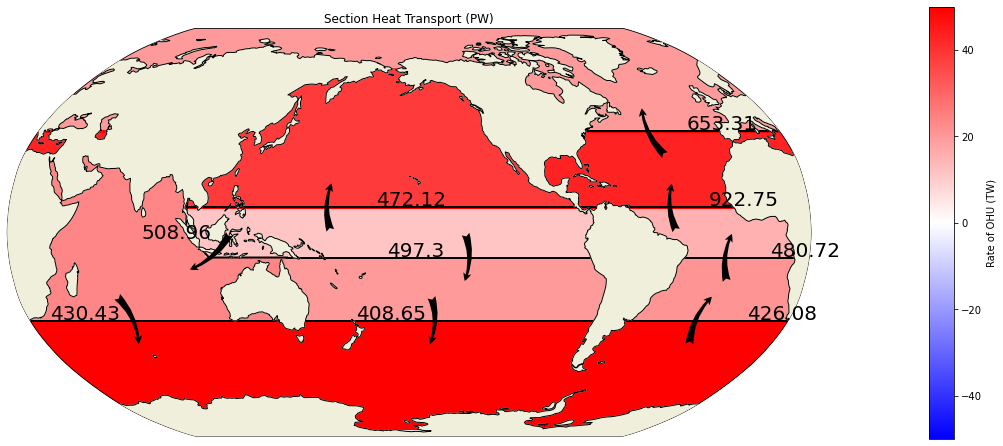

In [113]:
fig  = plt.figure(1, figsize = (17.5, 7.5))
gs = gridspec.GridSpec(1,1)
gs.update(wspace = 0.4, hspace=0)

ax1 = plt.subplot(gs[0,0], projection=ccrs.Robinson(central_longitude=-160))
minv, maxv = 0,8

ax1.stock_img()
ax1.coastlines(zorder=101)

## SECTIONS
# Pacific Sector
ax1.plot([145,300],[-35,-35], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([145,300],[-10,-10], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([100,280],[10,10], transform = ccrs.PlateCarree(), linewidth = 2, color='black')

# Indian Sector
ax1.plot([25,145],[-35,-35], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([145,110,100,100],[-10,-10,0,20], transform = ccrs.PlateCarree(), linewidth = 2, color='black')

# Atlantic Sector
ax1.plot([300,360],[-35,-35], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([0,25],[-35,-35], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([300,360],[-10,-10], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([0,25],[-10,-10], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([280,360],[10,10], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([280,360],[40,40], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([0,25],[40,40], transform = ccrs.PlateCarree(), linewidth = 2, color='black')

ax1.pcolormesh(lons, lats, np.nansum(OHU_remapped,axis=0), transform = ccrs.PlateCarree(), vmin=-50, vmax=50, cmap=plt.cm.bwr)
ax1.add_feature(cfeature.LAND, zorder=100)
cax = fig.add_axes([0.925, 0.12, 0.02, 0.8])
m = plt.cm.ScalarMappable(cmap='bwr')
m.set_clim(-50, 50)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('Rate of OHU (TW)')

## S PAC <> SO

if HF_section_tot[6]>0:
        ax1.annotate('', xy=(200,-25), xytext=(200, -45),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((HF_section_tot[6]).round(2)), xy=(200,-25), xytext=(220, -34.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=20, zorder=103)
else:
        ax1.annotate('', xy=(210,-45), xytext=(210, -25),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((HF_section_tot[6]).round(2)), xy=(175,-25), xytext=(175, -34.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=20, zorder=103)

## EQ PAC <> S PAC
if HF_section_tot[7]>0:

        ax1.annotate('', xy=(215,0), xytext=(215, -20),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((HF_section_tot[7]).round(2)), xy=(235,-9.5), xytext=(235, -9.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=20, zorder=103)
else:
        ax1.annotate('', xy=(225,-20), xytext=(225, 0),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((HF_section_tot[7]).round(2)), xy=(190,-9.5), xytext=(190, -9.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=20, zorder=103)

## EQ PAC <> N PAC
if HF_section_tot[8]>0:


        ax1.annotate('', xy=(165,20), xytext=(165, 0),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((HF_section_tot[8]).round(2)), xy=(185,10.5), xytext=(185, 10.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=20, zorder=103)
else:
        ax1.annotate('', xy=(175,0), xytext=(175, 20),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((HF_section_tot[8]).round(2)), xy=(140,10.5), xytext=(140, 10.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=20, zorder=103)

## IND <> SO
if HF_section_tot[4]>0:
        ax1.annotate('', xy=(55,-25), xytext=(55, -45),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)
        ax1.annotate(abs((HF_section_tot[4]).round(2)), xy=(75,-25), xytext=(75, -34.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=20, zorder=103)
else:
        ax1.annotate('', xy=(65,-45), xytext=(65, -25),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((HF_section_tot[4]).round(2)), xy=(30,-25), xytext=(30, -34.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=20, zorder=103)

## EQ PAC <> IND
if HF_section_tot[5]>0:
        ax1.annotate('', xy=(115, 7.5), xytext=(95,-7.5),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((HF_section_tot[5]).round(2)), xy=(75,-9.5), xytext=(120, -9.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=20, zorder=103)
else:
        ax1.annotate('', xy=(100, -15), xytext=(120,0),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((HF_section_tot[5]).round(2)), xy=(80,-2.5), xytext=(80, -2.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=20, zorder=103)


## S ATL <> SO
if HF_section_tot[3]>0:

        ax1.annotate('', xy=(340,-25), xytext=(340, -45),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((HF_section_tot[3]).round(2)), xy=(360,-25), xytext=(360, -34.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=20, zorder=103)
else:
        ax1.annotate('', xy=(350,-45), xytext=(350, -25),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((HF_section_tot[3]).round(2)), xy=(315,-25), xytext=(315, -34.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=20, zorder=103)

## EQ ATL <> S ATL
if HF_section_tot[2]>0:

        ax1.annotate('', xy=(345,0), xytext=(345, -20),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((HF_section_tot[2]).round(2)), xy=(2.5,-9.5), xytext=(2.5, -9.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=20, zorder=103)
else:
        ax1.annotate('', xy=(355,-20), xytext=(355, 0),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((HF_section_tot[2]).round(2)), xy=(320,-9.5), xytext=(320, -9.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=20, zorder=103)

## EQ ATL <> ST ATL
if HF_section_tot[1]>0:

        ax1.annotate('', xy=(320,20), xytext=(320, 0),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((HF_section_tot[1]).round(2)), xy=(335,10.5), xytext=(335, 10.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=20, zorder=103)
else:
        ax1.annotate('', xy=(330,0), xytext=(330, 20),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((HF_section_tot[1]).round(2)), xy=(295,10.5), xytext=(295, 10.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=20, zorder=103)

## ST ATL <> POL ATL
if HF_section_tot[0]>0:

        ax1.annotate('', xy=(320,50), xytext=(320, 30),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)
        ax1.annotate(abs((HF_section_tot[0]).round(2)), xy=(335,40.5), xytext=(335, 40.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=20, zorder=103)
else:
        ax1.annotate('', xy=(330,30), xytext=(330, 50),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((HF_section_tot[0]).round(2)), xy=(290,40.5), xytext=(290, 40.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=20, zorder=103)

ax1.set_title('Section Heat Transport (PW)')

if SF:
    plt.savefig('../Figures/Heat_fluxes_ACCESS_knownSF.png', bbox_inches='tight', dpi=300)
else:
    plt.savefig('../Figures/Heat_fluxes_ACCESS_freerun.png', bbox_inches='tight', dpi=300)
plt.show()

In [114]:
net_heat_trans_Basins = [HF_section_tot[0],\
    HF_section_tot[1]-HF_section_tot[0],\
        HF_section_tot[2]-HF_section_tot[1],\
            HF_section_tot[3]-HF_section_tot[2],\
                HF_section_tot[4]-HF_section_tot[5],\
                    HF_section_tot[6]-HF_section_tot[7],\
                        HF_section_tot[7]-HF_section_tot[8]+HF_section_tot[5],\
                            HF_section_tot[8],\
                            -HF_section_tot[4]-HF_section_tot[6]-HF_section_tot[3]]

net_salt_trans_Basins = [FWF_section_tot[0],\
    FWF_section_tot[1]-FWF_section_tot[0],\
        FWF_section_tot[2]-FWF_section_tot[1],\
            FWF_section_tot[3]-FWF_section_tot[2],\
                FWF_section_tot[4]-FWF_section_tot[5],\
                    FWF_section_tot[6]-FWF_section_tot[7],\
                        FWF_section_tot[7]-FWF_section_tot[8]+FWF_section_tot[5],\
                            FWF_section_tot[8],\
                            -FWF_section_tot[4]-FWF_section_tot[6]-FWF_section_tot[3]]

In [115]:
d = {'OHC Change [TW]': np.append(OHC_change, np.nansum(OHC_change)),\
    'Surface Heat flux Change [TW]': np.append(hfds_change, np.nansum(hfds_change)),\
            'Adjustment heat flux Change [TW]': np.append(hfds_adj_change, np.nansum(hfds_adj_change)),\
    'Net Meridional Heat Transport [TW]': np.append(net_heat_trans_Basins, np.nansum(net_heat_trans_Basins))}    
table = pd.DataFrame(data=d, index=np.append(Basins, 'Global'))

table

,OHC Change [TW],Surface Heat flux Change [TW],Adjustment heat flux Change [TW],Net Meridional Heat Transport [TW]
Polar N. Atlantic,19.801560,-767.183391,131.777661,6.533123e+02
Subtropical N. Atlantic,43.335840,-356.919885,125.337455,2.694416e+02
Eq. Atlantic,15.559423,393.519092,62.320671,-4.420312e+02
S. Atlantic,20.763602,-2.560688,80.799862,-5.463856e+01
Indian,23.586685,-270.016922,217.563871,7.852768e+01
S. Pacific,19.749229,-248.394224,191.031604,8.865199e+01
Eq. Pacific,11.429877,1297.212951,196.750539,-1.478380e+03
N. Pacific,38.383094,-751.172406,293.497911,4.721152e+02
Southern Ocean,86.599270,-754.542784,446.131520,4.130014e+02
Global,279.208580,-1460.058256,1745.211093,2.273737e-13


In [116]:
d = {'FW Change [Sv]': np.append(OSC_change, np.nansum(OSC_change)),\
    'Surface FW flux Change [Sv]': np.append(wfo_change, np.nansum(wfo_change)),\
            'Adjustment FW flux Change [Sv]': np.append(wfo_adj_change, np.nansum(wfo_adj_change)),\
    'Net Meridional FW Transport [Sv]': np.append(net_salt_trans_Basins, np.nansum(net_salt_trans_Basins))}    
table = pd.DataFrame(data=d, index=np.append(Basins, 'Global'))
table

,FW Change [Sv],Surface FW flux Change [Sv],Adjustment FW flux Change [Sv],Net Meridional FW Transport [Sv]
Polar N. Atlantic,0.011810,0.603475,-0.151841,4.400876e-01
Subtropical N. Atlantic,-0.045841,-0.445269,-0.144420,-5.425269e-01
Eq. Atlantic,-0.008320,0.346640,-0.072917,2.829570e-01
S. Atlantic,-0.006763,-0.355626,-0.093102,-4.426595e-01
Indian,-0.002573,-0.536180,-0.250688,-7.888352e-01
S. Pacific,0.022335,-0.324267,-0.220116,-5.692344e-01
Eq. Pacific,0.006828,0.963043,-0.226706,7.270995e-01
N. Pacific,0.031617,0.269641,-0.338183,-9.214855e-02
Southern Ocean,-0.006796,1.495329,-0.514055,9.852605e-01
Global,0.002297,2.016786,-2.012026,-1.110223e-16


In [117]:
d = {'OHC_Change': np.append(OHC_change, np.nansum(OHC_change)),\
    'Surface_Heat_flux_Change': np.append(hfds_change, np.nansum(hfds_change)),\
            'Adjustment_heat_flux_Change': np.append(hfds_adj_change, np.nansum(hfds_adj_change)),\
    'Net_Meridional_Heat_Transport': np.append(net_heat_trans_Basins, np.nansum(net_heat_trans_Basins))}    
table_HC = pd.DataFrame(data=d, index=np.append(Basins, 'Global'))
d = {'FW_Change': np.append(OSC_change, np.nansum(OSC_change)),\
    'Surface_FW_flux_Change': np.append(wfo_change, np.nansum(wfo_change)),\
            'Adjustment_FW_flux_Change': np.append(wfo_adj_change, np.nansum(wfo_adj_change)),\
    'Net_Meridional_FW_Transport': np.append(net_salt_trans_Basins, np.nansum(net_salt_trans_Basins))}    
table_FW = pd.DataFrame(data=d, index=np.append(Basins, 'Global'))


combi_HC_FW_pd = pd.concat([table_HC, table_FW], axis=1)
combi_HC_FW_ds = combi_HC_FW_pd.to_xarray()

In [118]:
# combi_HC_FW_ds.to_netcdf('../Optimisation_results/ACCESS_CM2_no_known_Q_prior_budget.nc')

In [119]:
budget_offset = xr.open_mfdataset('../Optimisation_results/ACCESS_CM2_known_offset_budget.nc')
budget_no_prior = xr.open_mfdataset('../Optimisation_results/ACCESS_CM2_no_known_Q_prior_budget.nc')
budget_prior = xr.open_mfdataset('../Optimisation_results/ACCESS_CM2_known_Q_prior_budget.nc')

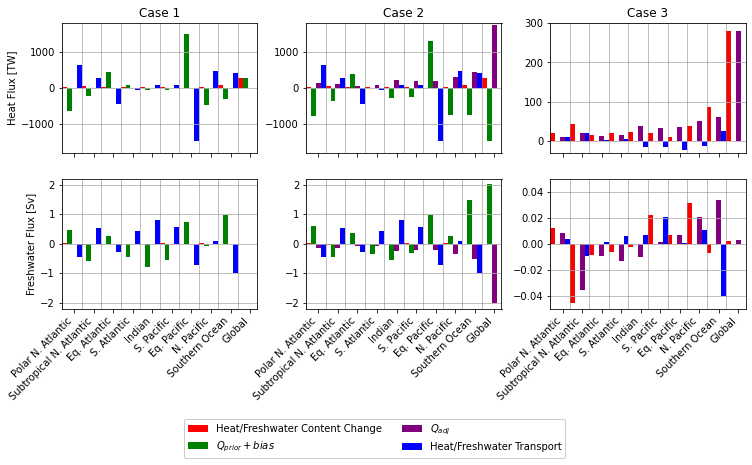

In [120]:
fig, axs = plt.subplots(2,3, figsize=(17.5*0.7,7.5*0.7), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .2, wspace=0.25)
axs = axs.ravel() 

axs[1].bar(np.arange(10), budget_offset.OHC_Change.values, 0.25, color='red')
axs[1].bar(np.arange(10)+0.25, budget_offset.Surface_Heat_flux_Change.values, 0.25, color='green')
axs[1].bar(np.arange(10)+0.5, budget_offset.Adjustment_heat_flux_Change.values, 0.25, color='purple')
axs[1].bar(np.arange(10)+0.75, budget_offset.Net_Meridional_Heat_Transport.values, 0.25, color='blue')

axs[0].bar(np.arange(10), budget_prior.OHC_Change.values, 0.25, color='red', label = 'Heat/Freshwater Content Change')
axs[0].bar(np.arange(10)+0.25, budget_prior.Surface_Heat_flux_Change.values, 0.25, color='green', label = '$Q_{prior}+bias$')
axs[0].bar(np.arange(10)+0.5, budget_prior.Adjustment_heat_flux_Change.values, 0.25, color='purple', label = '$Q_{adj}$')
axs[0].bar(np.arange(10)+0.75, budget_prior.Net_Meridional_Heat_Transport.values, 0.25, color='blue', label = 'Heat/Freshwater Transport')

axs[2].bar(np.arange(10), budget_no_prior.OHC_Change.values, 0.25, color='red')
axs[2].bar(np.arange(10)+0.25, budget_no_prior.Surface_Heat_flux_Change.values*0, 0.25, color='green')
axs[2].bar(np.arange(10)+0.5, budget_no_prior.Adjustment_heat_flux_Change.values, 0.25, color='purple')
axs[2].bar(np.arange(10)+0.75, budget_no_prior.Net_Meridional_Heat_Transport.values, 0.25, color='blue')

axs[4].bar(np.arange(10), budget_offset.FW_Change.values, 0.25, color='red')
axs[4].bar(np.arange(10)+0.25, budget_offset.Surface_FW_flux_Change.values, 0.25, color='green')
axs[4].bar(np.arange(10)+0.5, budget_offset.Adjustment_FW_flux_Change.values, 0.25, color='purple')
axs[4].bar(np.arange(10)+0.75, -budget_offset.Net_Meridional_FW_Transport.values, 0.25, color='blue')

axs[3].bar(np.arange(10), budget_prior.FW_Change.values, 0.25, color='red')
axs[3].bar(np.arange(10)+0.25, budget_prior.Surface_FW_flux_Change.values, 0.25, color='green')
axs[3].bar(np.arange(10)+0.5, budget_prior.Adjustment_FW_flux_Change.values, 0.25, color='purple')
axs[3].bar(np.arange(10)+0.75, -budget_prior.Net_Meridional_FW_Transport.values, 0.25, color='blue')

axs[5].bar(np.arange(10), budget_no_prior.FW_Change.values, 0.25, color='red')
axs[5].bar(np.arange(10)+0.25, budget_no_prior.Surface_FW_flux_Change.values*0, 0.25, color='green')
axs[5].bar(np.arange(10)+0.5, budget_no_prior.Adjustment_FW_flux_Change.values, 0.25, color='purple')
axs[5].bar(np.arange(10)+0.75, -budget_no_prior.Net_Meridional_FW_Transport.values, 0.25, color='blue')

axs[0].set_title('Case 1')
axs[1].set_title('Case 2')
axs[2].set_title('Case 3')

axs[0].set_ylim(-1800,1800)
axs[1].set_ylim(-1800,1800)
axs[2].set_ylim(-30,300)

axs[3].set_ylim(-2.2,2.2)
axs[4].set_ylim(-2.2,2.2)
axs[5].set_ylim(-0.05,0.05)


for i in range(6):
    axs[i].set_xticklabels(budget_no_prior.index.values, rotation=45, ha='right')
    axs[i].set_xticks(np.arange(10)+0.5)
    axs[i].set_xlim(-0.25/2,10-0.25/2)
    axs[i].vlines(np.arange(10)-0.25/2,-2000,2000, color='grey', linewidth=0.5)
    axs[i].grid(axis='y')
axs[0].set_xticklabels([])
axs[1].set_xticklabels([])
axs[2].set_xticklabels([])

axs[0].set_ylabel('Heat Flux [TW]')
axs[3].set_ylabel('Freshwater Flux [Sv]')

axs[0].legend(framealpha=1, ncol=2, bbox_to_anchor=(1.6, -2.2), loc='center')

plt.savefig('../Figures/Heat_FW_budgets.png', bbox_inches='tight', dpi=300)
plt.show()

In [121]:
hfds_lat_binned_global = xr.open_mfdataset('../../ACCESS_CM2/hfds_lat_binned_global.nc')
OHC_lat_binned_global = xr.open_mfdataset('../../ACCESS_CM2/OHC_lat_binned_global.nc')

hfds_lat_binned_Atl = xr.open_mfdataset('../../ACCESS_CM2/hfds_lat_binned_Atl.nc')
OHC_lat_binned_Atl = xr.open_mfdataset('../../ACCESS_CM2/OHC_lat_binned_Atl.nc')

hfds_lat_binned_Pac = xr.open_mfdataset('../../ACCESS_CM2/hfds_lat_binned_Pac.nc')
OHC_lat_binned_Pac = xr.open_mfdataset('../../ACCESS_CM2/OHC_lat_binned_Pac.nc')

hfds_lat_binned_Ind = xr.open_mfdataset('../../ACCESS_CM2/hfds_lat_binned_Ind.nc')
OHC_lat_binned_Ind = xr.open_mfdataset('../../ACCESS_CM2/OHC_lat_binned_Ind.nc')

hfds_lat_binned_SO = xr.open_mfdataset('../../ACCESS_CM2/hfds_lat_binned_SO.nc')
OHC_lat_binned_SO = xr.open_mfdataset('../../ACCESS_CM2/OHC_lat_binned_SO.nc')

In [122]:
wfo_lat_binned_global = xr.open_mfdataset('../../ACCESS_CM2/wfo_lat_binned_global.nc')
OSC_lat_binned_global = xr.open_mfdataset('../../ACCESS_CM2/OSC_lat_binned_global.nc')

wfo_lat_binned_Atl = xr.open_mfdataset('../../ACCESS_CM2/wfo_lat_binned_Atl.nc')
OSC_lat_binned_Atl = xr.open_mfdataset('../../ACCESS_CM2/OSC_lat_binned_Atl.nc')

wfo_lat_binned_Pac = xr.open_mfdataset('../../ACCESS_CM2/wfo_lat_binned_Pac.nc')
OSC_lat_binned_Pac = xr.open_mfdataset('../../ACCESS_CM2/OSC_lat_binned_Pac.nc')

wfo_lat_binned_Ind = xr.open_mfdataset('../../ACCESS_CM2/wfo_lat_binned_Ind.nc')
OSC_lat_binned_Ind = xr.open_mfdataset('../../ACCESS_CM2/OSC_lat_binned_Ind.nc')

wfo_lat_binned_SO = xr.open_mfdataset('../../ACCESS_CM2/wfo_lat_binned_SO.nc')
OSC_lat_binned_SO = xr.open_mfdataset('../../ACCESS_CM2/OSC_lat_binned_SO.nc')

In [123]:
OHC_early_lat_global = OHC_lat_binned_global.isel(time=slice(Early_period[0],Early_period[1])).mean('time') # J
OHC_late_lat_global = OHC_lat_binned_global.isel(time=slice(Late_period[0],Late_period[1])).mean('time') # J
hfds_early_lat_global = hfds_lat_binned_global.isel(time=slice(Early_period[0],Early_period[1])).mean('time') # J
hfds_late_lat_global = hfds_lat_binned_global.isel(time=slice(Late_period[0],Late_period[1])).mean('time') # J
hfds_lat_change_global = ((hfds_late_lat_global-hfds_early_lat_global)/(range_yrs*yr2sec*10**15)) # units: PW
OHC_lat_change_global = ((OHC_late_lat_global-OHC_early_lat_global)/(range_yrs*yr2sec*10**15)) # units: PW

OHC_early_lat_Atl = OHC_lat_binned_Atl.isel(time=slice(Early_period[0],Early_period[1])).mean('time') # J
OHC_late_lat_Atl = OHC_lat_binned_Atl.isel(time=slice(Late_period[0],Late_period[1])).mean('time') # J
hfds_early_lat_Atl = hfds_lat_binned_Atl.isel(time=slice(Early_period[0],Early_period[1])).mean('time') # J
hfds_late_lat_Atl = hfds_lat_binned_Atl.isel(time=slice(Late_period[0],Late_period[1])).mean('time') # J
hfds_lat_change_Atl = ((hfds_late_lat_Atl-hfds_early_lat_Atl)/(range_yrs*yr2sec*10**15)) # units: PW
OHC_lat_change_Atl = ((OHC_late_lat_Atl-OHC_early_lat_Atl)/(range_yrs*yr2sec*10**15)) # units: PW

OHC_early_lat_Pac = OHC_lat_binned_Pac.isel(time=slice(Early_period[0],Early_period[1])).mean('time') # J
OHC_late_lat_Pac = OHC_lat_binned_Pac.isel(time=slice(Late_period[0],Late_period[1])).mean('time') # J
hfds_early_lat_Pac = hfds_lat_binned_Pac.isel(time=slice(Early_period[0],Early_period[1])).mean('time') # J
hfds_late_lat_Pac = hfds_lat_binned_Pac.isel(time=slice(Late_period[0],Late_period[1])).mean('time') # J
hfds_lat_change_Pac = ((hfds_late_lat_Pac-hfds_early_lat_Pac)/(range_yrs*yr2sec*10**15)) # units: PW
OHC_lat_change_Pac = ((OHC_late_lat_Pac-OHC_early_lat_Pac)/(range_yrs*yr2sec*10**15)) # units: PW

OHC_early_lat_Ind = OHC_lat_binned_Ind.isel(time=slice(Early_period[0],Early_period[1])).mean('time') # J
OHC_late_lat_Ind = OHC_lat_binned_Ind.isel(time=slice(Late_period[0],Late_period[1])).mean('time') # J
hfds_early_lat_Ind = hfds_lat_binned_Ind.isel(time=slice(Early_period[0],Early_period[1])).mean('time') # J
hfds_late_lat_Ind = hfds_lat_binned_Ind.isel(time=slice(Late_period[0],Late_period[1])).mean('time') # J
hfds_lat_change_Ind = ((hfds_late_lat_Ind-hfds_early_lat_Ind)/(range_yrs*yr2sec*10**15)) # units: PW
OHC_lat_change_Ind = ((OHC_late_lat_Ind-OHC_early_lat_Ind)/(range_yrs*yr2sec*10**15)) # units: PW

OHC_early_lat_SO = OHC_lat_binned_SO.isel(time=slice(Early_period[0],Early_period[1])).mean('time') # J
OHC_late_lat_SO = OHC_lat_binned_SO.isel(time=slice(Late_period[0],Late_period[1])).mean('time') # J
hfds_early_lat_SO = hfds_lat_binned_SO.isel(time=slice(Early_period[0],Early_period[1])).mean('time') # J
hfds_late_lat_SO = hfds_lat_binned_SO.isel(time=slice(Late_period[0],Late_period[1])).mean('time') # J
hfds_lat_change_SO = ((hfds_late_lat_SO-hfds_early_lat_SO)/(range_yrs*yr2sec*10**15)) # units: PW
OHC_lat_change_SO = ((OHC_late_lat_SO-OHC_early_lat_SO)/(range_yrs*yr2sec*10**15)) # units: PW


In [124]:
north_HF_global = ((hfds_lat_change_global.__xarray_dataarray_variable__.cumsum('yt_ocean')\
    -OHC_lat_change_global.__xarray_dataarray_variable__.cumsum('yt_ocean'))).values

north_HF_Atl = ((hfds_lat_change_Atl.__xarray_dataarray_variable__.cumsum('yt_ocean')\
    -OHC_lat_change_Atl.__xarray_dataarray_variable__.cumsum('yt_ocean'))).values

north_HF_Pac = ((hfds_lat_change_Pac.__xarray_dataarray_variable__.cumsum('yt_ocean')\
    -OHC_lat_change_Pac.__xarray_dataarray_variable__.cumsum('yt_ocean'))).values

north_HF_Ind = ((hfds_lat_change_Ind.__xarray_dataarray_variable__.cumsum('yt_ocean')\
    -OHC_lat_change_Ind.__xarray_dataarray_variable__.cumsum('yt_ocean'))).values

north_HF_SO = ((hfds_lat_change_SO.__xarray_dataarray_variable__.cumsum('yt_ocean')\
    -OHC_lat_change_SO.__xarray_dataarray_variable__.cumsum('yt_ocean'))).values

global_lats = hfds_lat_change_global.yt_ocean.values

In [125]:
OSC_early_lat_global = OSC_lat_binned_global.isel(time=slice(Early_period[0],Early_period[1])).mean('time') # m3
OSC_late_lat_global = OSC_lat_binned_global.isel(time=slice(Late_period[0],Late_period[1])).mean('time') # m3
wfo_early_lat_global = wfo_lat_binned_global.isel(time=slice(Early_period[0],Early_period[1])).mean('time') # m3
wfo_late_lat_global = wfo_lat_binned_global.isel(time=slice(Late_period[0],Late_period[1])).mean('time') # m3
wfo_lat_change_global = ((wfo_late_lat_global-wfo_early_lat_global)/(range_yrs*yr2sec*10**6)) # units: Sv
OSC_lat_change_global = ((OSC_late_lat_global-OSC_early_lat_global)/(range_yrs*yr2sec*10**6)) # units: Sv

OSC_early_lat_Atl = OSC_lat_binned_Atl.isel(time=slice(Early_period[0],Early_period[1])).mean('time') # m3
OSC_late_lat_Atl = OSC_lat_binned_Atl.isel(time=slice(Late_period[0],Late_period[1])).mean('time') # m3
wfo_early_lat_Atl = wfo_lat_binned_Atl.isel(time=slice(Early_period[0],Early_period[1])).mean('time') # m3
wfo_late_lat_Atl = wfo_lat_binned_Atl.isel(time=slice(Late_period[0],Late_period[1])).mean('time') # m3
wfo_lat_change_Atl = ((wfo_late_lat_Atl-wfo_early_lat_Atl)/(range_yrs*yr2sec*10**6)) # units: Sv
OSC_lat_change_Atl = ((OSC_late_lat_Atl-OSC_early_lat_Atl)/(range_yrs*yr2sec*10**6)) # units: Sv

OSC_early_lat_Pac = OSC_lat_binned_Pac.isel(time=slice(Early_period[0],Early_period[1])).mean('time') # m3
OSC_late_lat_Pac = OSC_lat_binned_Pac.isel(time=slice(Late_period[0],Late_period[1])).mean('time') # m3
wfo_early_lat_Pac = wfo_lat_binned_Pac.isel(time=slice(Early_period[0],Early_period[1])).mean('time') # m3
wfo_late_lat_Pac = wfo_lat_binned_Pac.isel(time=slice(Late_period[0],Late_period[1])).mean('time') # m3
wfo_lat_change_Pac = ((wfo_late_lat_Pac-wfo_early_lat_Pac)/(range_yrs*yr2sec*10**6)) # units: Sv
OSC_lat_change_Pac = ((OSC_late_lat_Pac-OSC_early_lat_Pac)/(range_yrs*yr2sec*10**6)) # units: Sv

OSC_early_lat_Ind = OSC_lat_binned_Ind.isel(time=slice(Early_period[0],Early_period[1])).mean('time') # m3
OSC_late_lat_Ind = OSC_lat_binned_Ind.isel(time=slice(Late_period[0],Late_period[1])).mean('time') # m3
wfo_early_lat_Ind = wfo_lat_binned_Ind.isel(time=slice(Early_period[0],Early_period[1])).mean('time') # m3
wfo_late_lat_Ind = wfo_lat_binned_Ind.isel(time=slice(Late_period[0],Late_period[1])).mean('time') # m3
wfo_lat_change_Ind = ((wfo_late_lat_Ind-wfo_early_lat_Ind)/(range_yrs*yr2sec*10**6)) # units: Sv
OSC_lat_change_Ind = ((OSC_late_lat_Ind-OSC_early_lat_Ind)/(range_yrs*yr2sec*10**6)) # units: Sv

OSC_early_lat_SO = OSC_lat_binned_SO.isel(time=slice(Early_period[0],Early_period[1])).mean('time') # m3
OSC_late_lat_SO = OSC_lat_binned_SO.isel(time=slice(Late_period[0],Late_period[1])).mean('time') # m3
wfo_early_lat_SO = wfo_lat_binned_SO.isel(time=slice(Early_period[0],Early_period[1])).mean('time') # m3
wfo_late_lat_SO = wfo_lat_binned_SO.isel(time=slice(Late_period[0],Late_period[1])).mean('time') # m3
wfo_lat_change_SO = ((wfo_late_lat_SO-wfo_early_lat_SO)/(range_yrs*yr2sec*10**6)) # units: Sv
OSC_lat_change_SO = ((OSC_late_lat_SO-OSC_early_lat_SO)/(range_yrs*yr2sec*10**6)) # units: Sv


In [126]:
north_FWF_global = ((wfo_lat_change_global.__xarray_dataarray_variable__.cumsum('yt_ocean')\
    -OSC_lat_change_global.__xarray_dataarray_variable__.cumsum('yt_ocean'))).values

north_FWF_Atl = ((wfo_lat_change_Atl.__xarray_dataarray_variable__.cumsum('yt_ocean')\
    -OSC_lat_change_Atl.__xarray_dataarray_variable__.cumsum('yt_ocean'))).values

north_FWF_Pac = ((wfo_lat_change_Pac.__xarray_dataarray_variable__.cumsum('yt_ocean')\
    -OSC_lat_change_Pac.__xarray_dataarray_variable__.cumsum('yt_ocean'))).values

north_FWF_Ind = ((wfo_lat_change_Ind.__xarray_dataarray_variable__.cumsum('yt_ocean')\
    -OSC_lat_change_Ind.__xarray_dataarray_variable__.cumsum('yt_ocean'))).values

north_FWF_SO = ((wfo_lat_change_SO.__xarray_dataarray_variable__.cumsum('yt_ocean')\
    -OSC_lat_change_SO.__xarray_dataarray_variable__.cumsum('yt_ocean'))).values

In [127]:
tot = [0,HF_section_tot[0],\
    HF_section_tot[1]+HF_section_tot[8], \
        HF_section_tot[2]+HF_section_tot[7], \
            HF_section_tot[4]+HF_section_tot[6]+HF_section_tot[3],\
                0] 

tot_FW = [0,FWF_section_tot[0],\
    FWF_section_tot[1]+FWF_section_tot[8], \
        FWF_section_tot[2]+FWF_section_tot[7], \
            FWF_section_tot[4]+FWF_section_tot[6]+FWF_section_tot[3],\
                0] 


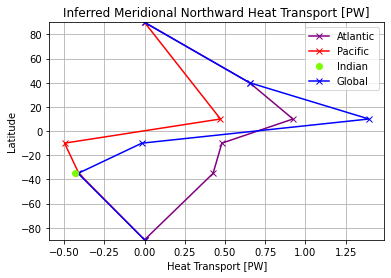

In [128]:

plt.plot(np.append(np.append(0,HF_section_tot[:4]),0)[::-1]/10**3, Atl_lats,  '-x', color='purple', label='Atlantic')
plt.plot(np.append(np.append(0,HF_section_tot[6:]),0)/10**3, Pac_lats, '-rx', label='Pacific')
plt.plot(HF_section_tot[4]/10**3, [-35], 'o', color='lawngreen', label='Indian',zorder=1000)
plt.plot(np.array(tot)/10**3, Atl_lats[::-1],  '-x', color='blue', label='Global')
# plt.fill_between(np.array(tot)/10**3, Atl_lats[::-1],-90,90, color='blue', alpha=0.3)
plt.grid()
# plt.vlines(0,-90,90, 'k')
plt.legend()
plt.ylim(-90,90)
plt.ylabel('Latitude')
plt.xlabel('Heat Transport [PW]')
plt.title('Inferred Meridional Northward Heat Transport [PW]')
plt.show()


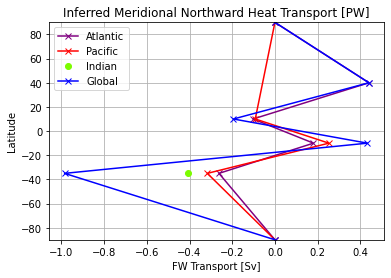

In [129]:
plt.plot(np.append(np.append(0,FWF_section_tot[:4]),0)[::-1], Atl_lats,  '-x', color='purple', label='Atlantic')
plt.plot(np.append(np.append(0,FWF_section_tot[6:]),0), Pac_lats, '-rx', label='Pacific')
plt.plot(FWF_section_tot[4], [-35], 'o', color='lawngreen', label='Indian',zorder=1000)
plt.plot(np.array(tot_FW), Atl_lats[::-1],  '-x', color='blue', label='Global')
# plt.fill_between(np.array(tot)/10**3, Atl_lats[::-1],-90,90, color='blue', alpha=0.3)
plt.grid()
# plt.vlines(0,-90,90, 'k')
plt.legend()
plt.ylim(-90,90)
plt.ylabel('Latitude')
plt.xlabel('FW Transport [Sv]')
plt.title('Inferred Meridional Northward Heat Transport [PW]')
plt.show()


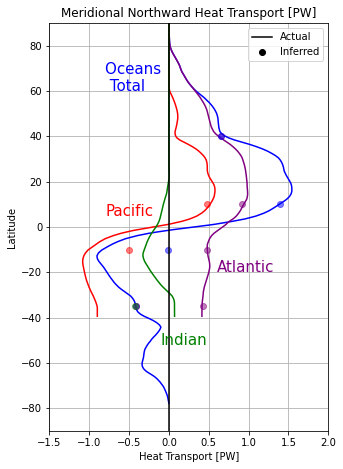

In [130]:
inds_SO = np.argwhere(global_lats>-40)

plt.figure(figsize=(5,7.5))

plt.plot(north_HF_global, global_lats, color='blue')
plt.plot(north_HF_global+20, global_lats, color='black', label='Actual')
plt.plot(north_HF_global+20, global_lats, 'ko', label='Inferred')

plt.plot((north_HF_Atl-north_HF_Atl[-1])[inds_SO], global_lats[inds_SO], color='purple')
plt.plot((north_HF_Pac-north_HF_Pac[-1])[inds_SO], global_lats[inds_SO], color='red')
plt.plot((north_HF_Ind-north_HF_Ind[-1])[inds_SO], global_lats[inds_SO], color='green')

plt.plot((np.append(np.append(0,HF_section_tot[:4]),0)[::-1]/10**3)[::-1][1:-1], Atl_lats[::-1][1:-1],  'o', color='purple', alpha=0.5)
plt.plot((np.append(np.append(0,HF_section_tot[6:]),0)/10**3)[::-1][1:-1], Pac_lats[::-1][1:-1], 'ro', alpha=0.5)
plt.plot((np.array(tot)/10**3)[1:-1], Atl_lats[::-1][1:-1],  'o', color='blue', alpha=0.5)
plt.plot(HF_section_tot[4]/10**3, [-35], 'o', color='green', alpha=0.5)

plt.legend()
plt.ylabel('Latitude')
plt.xlabel('Heat Transport [PW]')
plt.title('Meridional Northward Heat Transport [PW]')
plt.grid()
plt.ylim(-90,90)
plt.xlim(-1.5,2)
plt.text(-0.8,60,'Oceans \n Total', color='blue', fontsize=15)
plt.text(-0.8,5,'Pacific', color='red', fontsize=15)
plt.text(0.6,-20,'Atlantic', color='purple', fontsize=15)
plt.text(-0.1,-52,'Indian', color='green', fontsize=15)
plt.vlines(0,-90,90, color='black')
plt.savefig('../Figures/Heat_flux_validation.png', bbox_inches='tight', dpi=300)
plt.show()


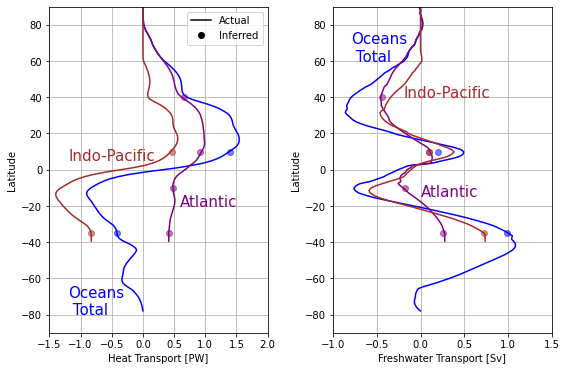

In [131]:
inds_SO = np.argwhere(global_lats>-40)

fig, axs = plt.subplots(1,2, figsize=(7.5*1.2,5*1.2), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=0.3)
axs = axs.ravel()

axs[0].plot(north_HF_global, global_lats, color='blue')
axs[0].plot(north_HF_global+20, global_lats, color='black', label='Actual')
axs[0].plot(north_HF_global+20, global_lats, 'ko', label='Inferred')

axs[0].plot((north_HF_Atl-north_HF_Atl[-1])[inds_SO], global_lats[inds_SO], color='purple')
axs[0].plot((north_HF_Pac-north_HF_Pac[-1])[inds_SO]+(north_HF_Ind-north_HF_Ind[-1])[inds_SO], global_lats[inds_SO], color='brown')

axs[0].plot(((HF_section_tot[:4])[::-1]/10**3)[::-1], Atl_lats[::-1][1:-1],  'o', color='purple', alpha=0.5)
axs[0].plot((np.array([HF_section_tot[6]+HF_section_tot[4], HF_section_tot[8]])/10**3)[::-1], [Pac_lats[::-1][1],Pac_lats[::-1][3]] , 'o', color='brown', alpha=0.5)
axs[0].plot((np.concatenate([tot[1:3],tot[4:]])/10**3)[1:-1], np.concatenate([Atl_lats[:2],Atl_lats[3:-1]])[::-1][1:-1],  'o', color='blue', alpha=0.5)
# plt.plot(/10**3, [-35], 'o', color='green', alpha=0.5)

axs[0].legend()
axs[0].set_ylabel('Latitude')
axs[0].set_xlabel('Heat Transport [PW]')
# axs[0].set_title('Meridional Northward Heat Transport [PW]')
axs[0].grid(zorder=-900)
axs[0].set_ylim(-90,90)
axs[0].set_xlim(-1.5,2)
axs[0].text(-1.2,-80,'Oceans\n Total', color='blue', fontsize=15)
axs[0].text(-1.2,5,'Indo-Pacific', color='brown', fontsize=15)
axs[0].text(0.6,-20,'Atlantic', color='purple', fontsize=15)

axs[1].plot(north_FWF_global, global_lats, color='blue')
axs[1].plot(north_FWF_global+20, global_lats, color='black', label='Actual')
axs[1].plot(north_FWF_global+20, global_lats, 'ko', label='Inferred')

axs[1].plot((north_FWF_Atl-north_FWF_Atl[-1])[inds_SO], global_lats[inds_SO], color='purple')
axs[1].plot((north_FWF_Pac-north_FWF_Pac[-1])[inds_SO]+(north_FWF_Ind-north_FWF_Ind[-1])[inds_SO], global_lats[inds_SO], color='brown')

axs[1].plot(-1*((FWF_section_tot[:4])[::-1])[::-1], Atl_lats[::-1][1:-1],  'o', color='purple', alpha=0.5)
axs[1].plot(-1*(np.array([FWF_section_tot[6]+FWF_section_tot[4], FWF_section_tot[8]]))[::-1], [Pac_lats[::-1][1],Pac_lats[::-1][3]] , 'o', color='brown', alpha=0.5)
axs[1].plot(-1*(np.concatenate([tot_FW[1:3],tot_FW[4:]]))[1:-1], np.concatenate([Atl_lats[:2],Atl_lats[3:-1]])[::-1][1:-1],  'o', color='blue', alpha=0.5)
# plt.plot(/10**3, [-35], 'o', color='green', alpha=0.5)

# axs[1].legend()
axs[1].set_ylabel('Latitude')
axs[1].set_xlabel('Freshwater Transport [Sv]')
# axs[1].set_title('Meridional Northward Freshwater Transport [Sv]')
axs[1].grid(zorder=-900)
axs[1].set_ylim(-90,90)
axs[1].set_xlim(-1,1.5)
axs[1].text(-0.8,60,'Oceans\n Total', color='blue', fontsize=15)
axs[1].text(-.2,40,'Indo-Pacific', color='brown', fontsize=15)
axs[1].text(0,-15,'Atlantic', color='purple', fontsize=15)
# plt.vlines(0,-90,90, color='black', zorder=-1000)
# plt.hlines(0,-2,2, color='black', zorder=-1000)

# plt.savefig('../Figures/Flux_validation_IPac.png', bbox_inches='tight', dpi=300)
plt.show()


In [132]:
import scipy.interpolate as interp

f_Atl_FWF = interp.interp1d(global_lats[inds_SO][:,0], (north_FWF_Atl-north_FWF_Atl[-1])[inds_SO][:,0])
f_IPac_FWF = interp.interp1d(global_lats[inds_SO][:,0], ((north_FWF_Pac-north_FWF_Pac[-1])[inds_SO]+(north_FWF_Ind-north_FWF_Ind[-1])[inds_SO])[:,0])

f_Atl_HF = interp.interp1d(global_lats[inds_SO][:,0], (north_HF_Atl-north_HF_Atl[-1])[inds_SO][:,0])
f_IPac_HF = interp.interp1d(global_lats[inds_SO][:,0], ((north_HF_Pac-north_HF_Pac[-1])[inds_SO]+(north_HF_Ind-north_HF_Ind[-1])[inds_SO])[:,0])

Atl_actual_interped_FWF = f_Atl_FWF(Atl_lats[::-1][1:-1])
IPac_actual_interped_FWF = f_IPac_FWF([Pac_lats[::-1][1],Pac_lats[::-1][3]])

Atl_actual_interped_HF = f_Atl_HF(Atl_lats[::-1][1:-1])
IPac_actual_interped_HF = f_IPac_HF([Pac_lats[::-1][1],Pac_lats[::-1][3]])


Atl_std_FWF = np.std(Atl_actual_interped_FWF-(-1*((FWF_section_tot[:4])[::-1])[::-1]))
IPac_std_FWF = np.std(IPac_actual_interped_FWF-(-1*(np.array([FWF_section_tot[6]+FWF_section_tot[4], FWF_section_tot[8]]))[::-1]))

Atl_std_HF = np.std(Atl_actual_interped_HF-(((HF_section_tot[:4])[::-1])[::-1])/10**3)
IPac_std_HF = np.std(IPac_actual_interped_HF-((np.array([HF_section_tot[6]+HF_section_tot[4], HF_section_tot[8]]))[::-1])/10**3)


print('std_Atl_FWF = '+str(Atl_std_FWF))
print('std_IPac_FWF = '+str(IPac_std_FWF))

print('std_Atl_HF = '+str(Atl_std_HF))
print('std_IPac_HF = '+str(IPac_std_HF))

std_Atl_FWF = 0.013765698585990542
std_IPac_FWF = 0.14242766164379003
std_Atl_HF = 0.016326347010915523
std_IPac_HF = 0.016994835992275387


In [ ]:
# Biased
std_Atl_FWF = 0.013765698585990542
std_IPac_FWF = 0.14242766164379003
std_Atl_HF = 0.016326347010915523
std_IPac_HF = 0.016994835992275387
# No bias

std_Atl_FWF = 0.013775865506327001
std_IPac_FWF = 0.14231712361755983
std_Atl_HF = 0.016354144014653103
std_IPac_HF = 0.01673225180585375


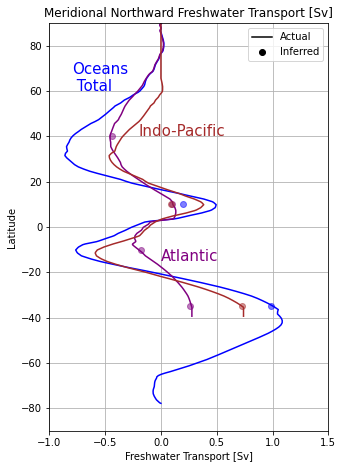

In [45]:
inds_SO = np.argwhere(global_lats>-40)

plt.figure(figsize=(5,7.5))

plt.plot(north_FWF_global, global_lats, color='blue')
plt.plot(north_FWF_global+20, global_lats, color='black', label='Actual')
plt.plot(north_FWF_global+20, global_lats, 'ko', label='Inferred')

plt.plot((north_FWF_Atl-north_FWF_Atl[-1])[inds_SO], global_lats[inds_SO], color='purple')
plt.plot((north_FWF_Pac-north_FWF_Pac[-1])[inds_SO]+(north_FWF_Ind-north_FWF_Ind[-1])[inds_SO], global_lats[inds_SO], color='brown')

plt.plot(-1*((FWF_section_tot[:4])[::-1])[::-1], Atl_lats[::-1][1:-1],  'o', color='purple', alpha=0.5)
plt.plot(-1*(np.array([FWF_section_tot[6]+FWF_section_tot[4], FWF_section_tot[8]]))[::-1], [Pac_lats[::-1][1],Pac_lats[::-1][3]] , 'o', color='brown', alpha=0.5)
plt.plot(-1*(np.concatenate([tot_FW[1:3],tot_FW[4:]]))[1:-1], np.concatenate([Atl_lats[:2],Atl_lats[3:-1]])[::-1][1:-1],  'o', color='blue', alpha=0.5)
# plt.plot(/10**3, [-35], 'o', color='green', alpha=0.5)

plt.legend()
plt.ylabel('Latitude')
plt.xlabel('Freshwater Transport [Sv]')
plt.title('Meridional Northward Freshwater Transport [Sv]')
plt.grid(zorder=-900)
plt.ylim(-90,90)
plt.xlim(-1,1.5)
plt.text(-0.8,60,'Oceans\n Total', color='blue', fontsize=15)
plt.text(-.2,40,'Indo-Pacific', color='brown', fontsize=15)
plt.text(0,-15,'Atlantic', color='purple', fontsize=15)
# plt.vlines(0,-90,90, color='black', zorder=-1000)
# plt.hlines(0,-2,2, color='black', zorder=-1000)

plt.savefig('../Figures/FW_flux_validation_IPac.png', bbox_inches='tight', dpi=300)
plt.show()


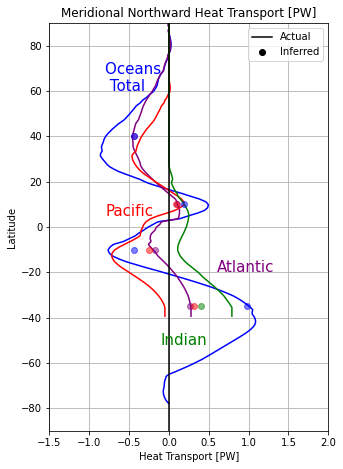

In [46]:
inds_SO = np.argwhere(global_lats>-40)

plt.figure(figsize=(5,7.5))

plt.plot(north_FWF_global, global_lats, color='blue')
plt.plot(north_FWF_global+20, global_lats, color='black', label='Actual')
plt.plot(north_FWF_global+20, global_lats, 'ko', label='Inferred')

plt.plot((north_FWF_Atl-north_FWF_Atl[-1])[inds_SO], global_lats[inds_SO], color='purple')
plt.plot((north_FWF_Pac-north_FWF_Pac[-1])[inds_SO], global_lats[inds_SO], color='red')
plt.plot((north_FWF_Ind-north_FWF_Ind[-1])[inds_SO], global_lats[inds_SO], color='green')

plt.plot(-1*(np.append(np.append(0,FWF_section_tot[:4]),0)[::-1])[::-1][1:-1], Atl_lats[::-1][1:-1],  'o', color='purple', alpha=0.5)
plt.plot(-1*(np.append(np.append(0,FWF_section_tot[6:]),0))[::-1][1:-1], Pac_lats[::-1][1:-1], 'ro', alpha=0.5)
plt.plot(-1*(np.array(tot_FW))[1:-1], Atl_lats[::-1][1:-1],  'o', color='blue', alpha=0.5)
plt.plot(-1*FWF_section_tot[4], [-35], 'o', color='green', alpha=0.5)

plt.legend()
plt.ylabel('Latitude')
plt.xlabel('Heat Transport [PW]')
plt.title('Meridional Northward Heat Transport [PW]')
plt.grid()
plt.ylim(-90,90)
plt.xlim(-1.5,2)
plt.text(-0.8,60,'Oceans \n Total', color='blue', fontsize=15)
plt.text(-0.8,5,'Pacific', color='red', fontsize=15)
plt.text(0.6,-20,'Atlantic', color='purple', fontsize=15)
plt.text(-0.1,-52,'Indian', color='green', fontsize=15)
plt.vlines(0,-90,90, color='black')
# plt.savefig('../Figures/Heat_flux_validation.png', bbox_inches='tight', dpi=300)
plt.show()


In [46]:
psi_TS = xr.open_mfdataset('TS_Sfunction/FULL_psi_TS_ACCESS_piC.nc')

OSError: no files to open

In [54]:
G1 = np.zeros_like(g_ij)
G2 = np.zeros_like(g_ij)
for i in (range(g_ij.shape[0])):
    for j in (range(g_ij.shape[1])):
        if i>j:
            G1[j,i] = g_ij[i,j]
        elif j>i:
            G2[i,j] = g_ij[i,j]

asymmetric = G1-G2

In [55]:
from tqdm import tqdm
T_star = psi_TS.temp.values
S_star = psi_TS.salt.values

psi = np.zeros((S_star.size, T_star.size))
for i in tqdm(range(g_ij.shape[0])):
    for j in (range(g_ij.shape[1])):
        if (g_ij[i,j]!=0):
            for k in (range(S_star.size)):
                if (S_1[i]<S_star[k]-35)&(S_star[k]-35<=S_2[j]):
                    temp = T_1[i]+(S_star[k]-35-S_1[i])*((T_2[j]-T_1[i])/(S_2[j]-S_1[i]))
                    psi[k,np.argmax(T_star > temp)] = psi[k,np.argmax(T_star > temp)]+abs(asymmetric[i,j])

for i in tqdm(range(g_ij.shape[0])):
    for j in (range(g_ij.shape[1])):
        if (g_ij[i,j]!=0):
            for k in (range(S_star.size)):
                if (S_1[i]>=S_star[k]-35)&(S_star[k]-35>S_2[j]):
                    temp = T_1[i]+(S_star[k]-35-S_1[i])*((T_2[j]-T_1[i])/(S_2[j]-S_1[i]))
                    psi[k,np.argmax(T_star > temp)] = psi[k,np.argmax(T_star > temp)]-abs(asymmetric[i,j])

100%|██████████| 144/144 [00:00<00:00, 257.77it/s]


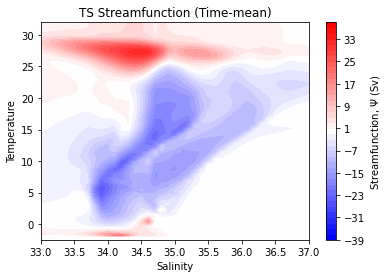

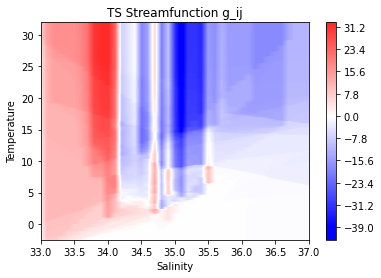

In [56]:

im = (-psi_TS.__xarray_dataarray_variable__).mean('time').T.plot.contourf(levels=40, vmin=-39, vmax=39, cmap=plt.cm.bwr, add_colorbar=False)
plt.ylim(-2.5,32)
plt.xlim(33,37)

cb = plt.colorbar(im)
cb.set_label('Streamfunction, $\Psi$ (Sv)')
plt.xlabel('Salinity')
plt.ylabel('Temperature')
plt.title('TS Streamfunction (Time-mean)')
plt.show()

plt.contourf(S_star, T_star, np.cumsum(psi, axis=-1).T/(range_yrs*yr2sec*10**6), vmin=-39, vmax=39, levels=500, cmap=plt.cm.bwr)
plt.colorbar()
plt.ylim(-2.5,32)
plt.xlim(33,37)
plt.xlabel('Salinity')
plt.ylabel('Temperature')
plt.title('TS Streamfunction g_ij')
plt.show()

-------------

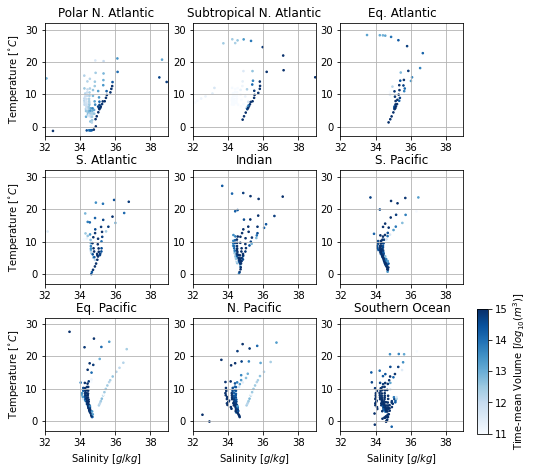

In [15]:
fig, axs = plt.subplots(3,3, figsize=(7.5,7.5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3, wspace=0.2)
axs = axs.ravel() 
cax = fig.add_axes([0.925, 0.12, 0.02, 0.23])

minv, maxv = 11,15
cmap = 'Blues'

for bx in range(Basins.size):
    axs[bx].scatter(SA_early[bx,:],CT_early[bx,:], 10, np.log10(V_early[bx,:]),cmap=cmap, vmin=minv, vmax=maxv, marker = '.')
    axs[bx].set_xlim(32,39)
    axs[bx].set_ylim(-3,32)
    axs[bx].set_title(Basins[bx])
    if bx==0 or bx==3 or bx==6:
        axs[bx].set_ylabel('Temperature [$^{\circ}C$]')
    if bx==6 or bx==7 or bx==8:
        axs[bx].set_xlabel('Salinity [$g/kg$]')
    axs[bx].grid()
    
m = plt.cm.ScalarMappable(cmap=cmap)
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('Time-mean Volume [$log_{10}(m^3)$]') 
if SF:
    plt.savefig('Figures/BSP_clustering_mean_volumes_ACCESS_Vbased_SF.png', bbox_inches='tight', dpi=300)
else:
    plt.savefig('Figures/BSP_clustering_mean_volumes_ACCESS_Vbased.png', bbox_inches='tight', dpi=300)
plt.show()

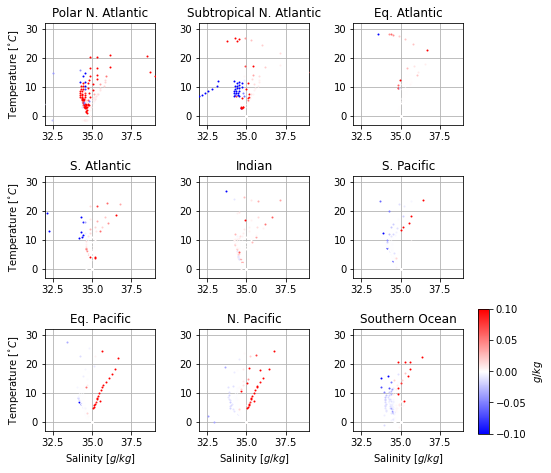

CPU times: user 14.8 s, sys: 561 ms, total: 15.3 s
Wall time: 15.2 s


In [16]:
%%time
fig, axs = plt.subplots(3,3, figsize=(7.5,7.5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=0.4)
axs = axs.ravel() 
cax = fig.add_axes([0.927, 0.12, 0.02, 0.23])

minv, maxv = -.1,.1
cmap = plt.cm.bwr
norm = plt.Normalize(minv, maxv)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

k=0
for i in range(np.array(Basins).size):
    for j in range(SA_early.shape[1]):
        axs[i].scatter(0.5*(S_1[k]+S_2[k]+S0*2), 0.5*(T_1[k]+T_2[k]), 1, color=cmap(norm(Opt_result.dS_adjustment[k])), zorder=100)
        axs[i].set_xlim(32,39)
        axs[i].set_ylim(-3,32)
        axs[i].set_title(Basins[i])
        axs[i].grid(True)
        k=k+1
    if i==0 or i==3 or i==6:
        axs[i].set_ylabel('Temperature [$^{\circ}C$]')
    if i==6 or i==7 or i==8:
        axs[i].set_xlabel('Salinity [$g/kg$]')
m = plt.cm.ScalarMappable(cmap='bwr')
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('$g/kg$')
plt.show()

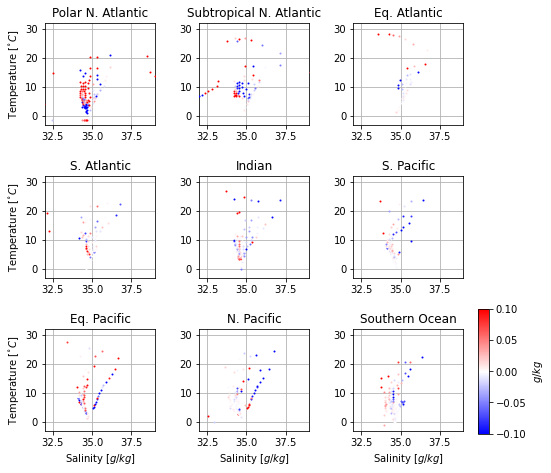

CPU times: user 14.9 s, sys: 579 ms, total: 15.5 s
Wall time: 15.3 s


In [17]:
%%time
fig, axs = plt.subplots(3,3, figsize=(7.5,7.5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=0.4)
axs = axs.ravel() 
cax = fig.add_axes([0.927, 0.12, 0.02, 0.23])

minv, maxv = -.1,.1
cmap = plt.cm.bwr
norm = plt.Normalize(minv, maxv)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

k=0
for i in range(np.array(Basins).size):
    for j in range(SA_early.shape[1]):
        axs[i].scatter(0.5*(S_1[k]+S_2[k]+S0*2), 0.5*(T_1[k]+T_2[k]), 1, color=cmap(norm(Opt_result.dS_mixing[k])), zorder=100)
        axs[i].set_xlim(32,39)
        axs[i].set_ylim(-3,32)
        axs[i].set_title(Basins[i])
        axs[i].grid(True)
        k=k+1
    if i==0 or i==3 or i==6:
        axs[i].set_ylabel('Temperature [$^{\circ}C$]')
    if i==6 or i==7 or i==8:
        axs[i].set_xlabel('Salinity [$g/kg$]')
m = plt.cm.ScalarMappable(cmap='bwr')
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('$g/kg$')
plt.show()

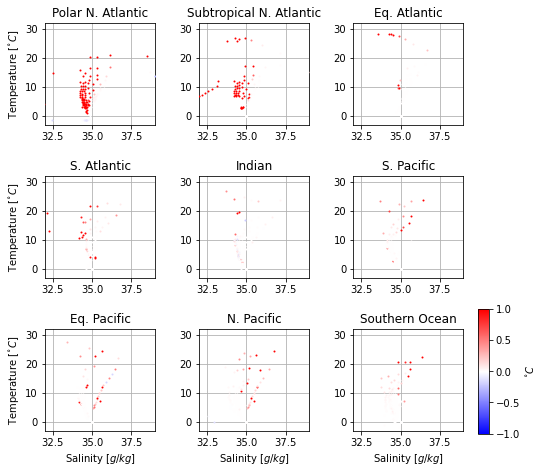

CPU times: user 14.8 s, sys: 561 ms, total: 15.3 s
Wall time: 15.2 s


In [18]:
%%time
fig, axs = plt.subplots(3,3, figsize=(7.5,7.5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=0.4)
axs = axs.ravel() 
cax = fig.add_axes([0.927, 0.12, 0.02, 0.23])

minv, maxv = -1,1
cmap = plt.cm.bwr
norm = plt.Normalize(minv, maxv)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

k=0
for i in range(np.array(Basins).size):
    for j in range(SA_early.shape[1]):
        axs[i].scatter(0.5*(S_1[k]+S_2[k]+S0*2), 0.5*(T_1[k]+T_2[k]), 1, color=cmap(norm(Opt_result.dT_adjustment[k])), zorder=100)
        axs[i].set_xlim(32,39)
        axs[i].set_ylim(-3,32)
        axs[i].set_title(Basins[i])
        axs[i].grid(True)
        k=k+1
    if i==0 or i==3 or i==6:
        axs[i].set_ylabel('Temperature [$^{\circ}C$]')
    if i==6 or i==7 or i==8:
        axs[i].set_xlabel('Salinity [$g/kg$]')
m = plt.cm.ScalarMappable(cmap='bwr')
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('$^{\circ}C$')
plt.show()

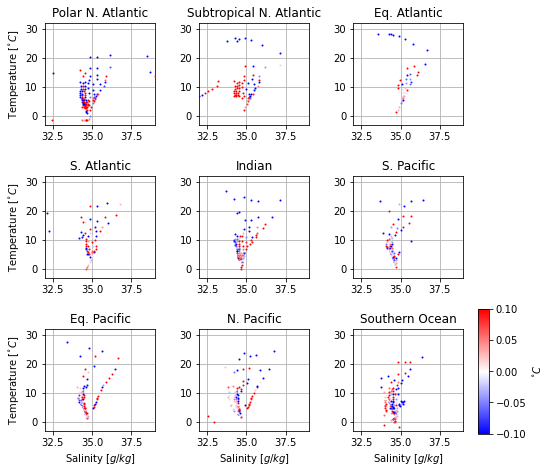

CPU times: user 15.3 s, sys: 604 ms, total: 15.9 s
Wall time: 15.7 s


In [19]:
%%time
fig, axs = plt.subplots(3,3, figsize=(7.5,7.5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=0.4)
axs = axs.ravel() 
cax = fig.add_axes([0.927, 0.12, 0.02, 0.23])

minv, maxv = -.1,.1
cmap = plt.cm.bwr
norm = plt.Normalize(minv, maxv)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

k=0
for i in range(np.array(Basins).size):
    for j in range(SA_early.shape[1]):
        axs[i].scatter(0.5*(S_1[k]+S_2[k]+S0*2), 0.5*(T_1[k]+T_2[k]), 1, color=cmap(norm(Opt_result.dT_mixing[k])), zorder=100)
        axs[i].set_xlim(32,39)
        axs[i].set_ylim(-3,32)
        axs[i].set_title(Basins[i])
        axs[i].grid(True)
        k=k+1
    if i==0 or i==3 or i==6:
        axs[i].set_ylabel('Temperature [$^{\circ}C$]')
    if i==6 or i==7 or i==8:
        axs[i].set_xlabel('Salinity [$g/kg$]')
m = plt.cm.ScalarMappable(cmap='bwr')
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('$^{\circ}C$')
plt.show()